<a href="https://colab.research.google.com/github/uervitonsantos/Otimizacao-Politicaca-Manutencao-Preventiva-Imperfeita/blob/main/Algoritmo_PSO_para_otimiza%C3%A7%C3%A3o_de_custo_de_manuten%C3%A7%C3%A3o_preventiva_v9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Dataset de dados de confiabilidade: https://drive.google.com/drive/folders/1b7jqK1A2XI1oZ4YhDXw_4xdnSTbfuBVK?usp=sharing

In [975]:
%%capture
pip install pyswarms

In [976]:
import numpy as np
import pandas as pd
import math
import csv
import matplotlib.pyplot as plt
import time
from pyswarms.single.global_best import GlobalBestPSO
import pyswarms as ps
from pyswarms.utils.search import RandomSearch
from pyswarms.utils.functions import single_obj as fx
from pyswarms.utils.plotters import (plot_cost_history, plot_contour, plot_surface)
import plotly.graph_objects as go
from pyswarms.utils.plotters.formatters import Designer
from pyswarms.utils.plotters.formatters import Mesher
from mpl_toolkits.mplot3d import Axes3D

In [977]:
MAX_VALUE_CUSTO = 10000
fator_melhoria = 'expo'
DIAS_OBSERVADOS = 600

In [978]:
# Custos MC e MP
CMC = 4000
CMP = 2000

In [979]:
class IntensidadeFalha:
    # Este método vai inicializar cada objeto criado a partir desta classe
    # O nome deste método é "inicio"
    # (self) é uma referência a cada atributo de um objeto criado a partir desta classe
    # Os atributos de cada objeto criados a partir desta classe.
    # O self indica que estes são atributos dos objetos
    def __init__(self):
        self.fator = None
        self.lamb = None
        self.beta = None
        self.theta = None
        self.sz = None
        self.T = None
        self.u = None

    def inicio(self, T, fator, solucao):
        self.fator = fator
        self.lamb = solucao[0]
        self.beta = solucao[1]
        self.theta = solucao[2]
        self.sz = int(T[-1])
        self.T = T

    def create(self):
        self.u = []
        # Reducao de Idade com fator de melhoria linear
        for i, tc in enumerate(self.T[1:], start=1):
            for tt in range(int(self.T[i-1]), int(tc)+1):
                b = tt - self.fator[0][i-1] * self.T[i-1]
                self.u.append((1 / (self.lamb ** self.beta)) * self.beta * b ** (self.beta - 1))

                if tt == tc:
                    self.u.append(float('nan'))
            break
    # plota e salva a figura da função de intensidade de falha
    def plotar(self):
        fig = plt.figure(figsize=(20, 5))
        plt.plot(self.u)

        for xc in self.T:
            plt.axvline(x=xc, color='r', linestyle='--')

        plt.xlabel("Tempo (dias)")
        plt.ylabel("Função intensidade de falha")
        plt.xlim(0)
        plt.grid(True)
        plt.show()

In [980]:
# Define a função de melhoria constante
def const(ck, m, s, theta):
    fator = [[theta] * ck] * m
    return fator

In [981]:
# Define a função de melhoria linear
def linear(ck, m, s, theta):
    fator = []
    for k in range(0, m, 1):
        linha = [0]
        for j in range(0, ck, 1):
            linha.append(s[k][j] * theta)
        fator.append(linha)
    return fator

In [982]:
 # Define a função de melhoria exponencial
def expo(ck, m, s, theta):
    fator = []
    for k in range(0, m, 1):
        linha = []
        for j in range(0, ck, 1):
            linha.append(1.0 - np.exp(-s[k][j] * theta))
        fator.append(linha)
    return fator

In [983]:
# Define a função de melhoria potência
def pot(ck, m, s, theta):
    fator = []
    for k in range(0, m, 1):
        linha = []
        for j in range(0, ck, 1):
            linha.append(s[k][j] ** theta)
        fator.append(linha)
    return fator

In [984]:
# Define a função de melhoria para manutenção perfeita
def mpp(ck, m, s, theta):
    fator = []
    for k in range(0, m, 1):
        linha = []
        for j in range(0, ck, 1):
            linha.append(1)
        fator.append(linha)
    return fator

In [985]:
# Executa a função de melhoria com base no parâmetro fornecido
def execute_function(fator_melhoria, ck, m, s, theta):
    return {
        'const': lambda: const(ck, m, s, theta),
        'linear': lambda: linear(ck, m, s, theta),
        'expo': lambda: expo(ck, m, s, theta),
        'pot': lambda: pot(ck, m, s, theta),
        'mpp': lambda: mpp(ck, m, s, theta),
    }[fator_melhoria]()

In [986]:
# Função custo de manutenção baseada em severidade
def custo_mp(s, CMP):
    dist = {0.25: 2000, 0.5: 4000, 0.75: 12000, 1.0: 20000}
    if not isinstance(s, list):
        s = [s]  # Transforma s em uma lista com um único elemento
    cmp_f = np.sum([CMP if si < 0.25 or si > 1.0 else np.interp(si, [0.25, 0.5, 0.75, 1.0], [2000, 4000, 12000, 20000]) for si in s])
    return cmp_f

In [987]:
# Leitura dos dados de tempo: exemplo tese Marcos Coque Jr.
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/DateSet/Cenarios/cenario01.csv', sep=";")
df.head()

,t,k,c,n,s,T
0,90,1,1,4.0,0.4,0.0
1,110,1,1,0.0,0.5,150.0
2,125,1,1,9.0,0.9,250.0
3,135,1,1,2.0,0.2,500.0
4,295,1,3,2.0,0.4,600.0


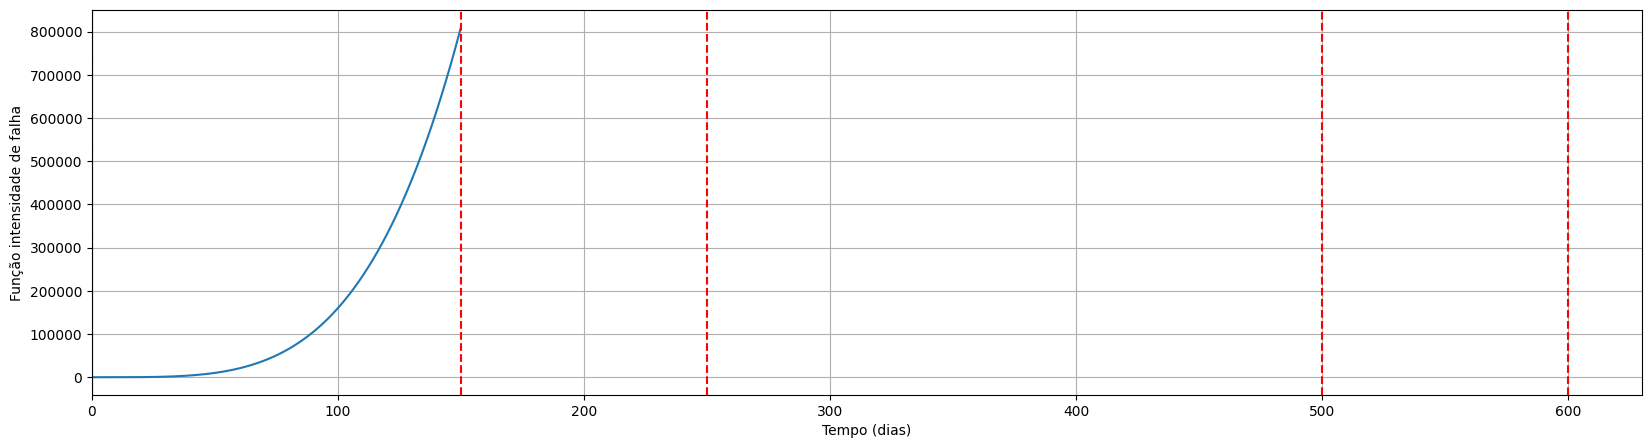

Fator ajuste:  [0.5506710358827784, 0.6321205588285577, 0.8347011117784134, 0.3296799539643607]


In [988]:
# Cria as variaveis
# tempos de falhas
t = df['t']
# indice do sistema
k = df['k']
m = k.drop_duplicates().shape[0]
# Numero de ciclos de manutenção
ck = df['c'].max()
# Numero de falhas e severidade das manutenções preventivas em cada sistema
n = []
s = []
for k in range(m):
    n.append(list(df['n'][k * ck:(k + 1) * ck]))
    s.append(list(df['s'][k * ck:(k + 1) * ck]))

# Tempos das MP
T = list(df['T'][:m])

# Criação de variáveis para os parâmetros
lamb = 5
theta = 2

# Cria alguns cenários de teste
beta = 5

solucao = [lamb, beta, theta]

# Cria a instância da classe IntensidadeFalha
intensidadeFalha = IntensidadeFalha()

# Inicializa a instância com os valores necessários
falha = intensidadeFalha.inicio(T, execute_function(fator_melhoria, ck, m, s, theta), solucao)

# Cria os dados da intensidade de falha
intensidadeFalha.create()

# Plota o gráfico da intensidade de falha
intensidadeFalha.plotar()

fator = execute_function(fator_melhoria, ck, m, s, theta)
print('Fator ajuste: ', fator[0])

last_value_fator_ajuste = fator[0][-1]

time_duration = 1
time.sleep(time_duration)

In [989]:
# Função objetivo para otimização da politica de manutenção
# Numero de ciclos determinado pela solução
# Solução com 24 valores reais
# Solucao a ser avaliada X = [x1, ..., x24]
def objective_st(x):

    # Dicionario para severidades
    dict_severidades = {1: 0.25, 3: 0.50, 5: 0.75, 7: 1.0}

    results = [] # Lista para armazenar os resultados das funções objetivo


    # No PSO, como cada particula é um vetor de dimenções definidas, é
    # Necessario interar sobre o vetor de particulas
    for particle in x:
        T = [0]
        s_row = []
        cont = 0

        for number in particle:
            modulo = int(number) % 2
            if modulo == 1:
                inteiro = int(number)
                s_row.append(dict_severidades[inteiro])  # Severidade
                frac = number - inteiro  # Tempo
                t = (cont + frac) * 30
                T.append(int(t))
            cont += 1

    s = []
    for row in range(m):
        s.append(s_row)

    # A partir da solução define o número de ciclos
    # A variável m é o número de sistemas em análise: em nosso exemplo m = 4
    # Para novos dados esse parâmetro deve ser ajustado
    # m = 4
    ck = len(T) - 1

    print("")
    print("=========================================================================")
    print("")
    print('Número de ciclos de manutenção:', ck, m)
    print('Tempos para manutenções preventivas:', T)
    print('Severidade para cada subsistema:', s[0])
    print("Número de Sisemas:", m)

    if ck == 0:
        return MAX_VALUE_CUSTO

    # O modelo já está ajustado
    # Utilizado para avaliar a solução candidata

    # Cria fator de meloria a partir da solução
    fact = execute_function(fator_melhoria, ck, m, s, theta)
    fator = [last_value_fator_ajuste] + list(fact[0])

    print('Fator: ', fator)

    # Numero esperado de falhas (NEF) em cada ciclo
    termos_somatorio = [((1/(lamb**beta)) * (T[1]**beta))]
    numero_medio_falhas = [0, ((1/(lamb**beta)) * (T[1]**beta))]

    for i in range(ck-1):
        termo = (((T[i+2]-fator[i]*T[i+1])**beta) - (((1-fator[i])*T[i+1])**beta)) * (1/(lamb**beta))
        termos_somatorio.append(termo)
        numero_medio_falhas.append(sum(termos_somatorio))

    # Número médio de falhas até o final do período: 2 anos
    final = DIAS_OBSERVADOS
    termo = (((final-fator[ck-1]*T[ck])**beta) - (((1-fator[ck-1])*T[ck])**beta)) * (1/(lamb**beta))
    termos_somatorio.append(termo)
    numero_medio_falhas.append(sum(termos_somatorio))

    mi = numero_medio_falhas

    print('Media de falhas: ', mi)

    Ctotal =  []

    for i in range(ck):
        cmp = custo_mp(s[0][i], CMP)
        Ctotal.append((cmp + (mi[i+1] - mi[i])*CMC)/(T[i+1]-T[i]))

    cmp = custo_mp(s[0][ck-1], CMP)
    Ctotal.append((cmp + (mi[ck+1] - mi[ck])*CMC)/(final-T[ck]))

    # Custo Total
    Custo = np.sum(Ctotal)
    results.append(Custo) # Adicione o valor da função objetivo à lista de resultados
    print('Custo = ', Custo)

    # Retorne os resultados da função objetivo como um array
    return np.array(results)

In [990]:
num_particles = 100
max_iterations = 100
dimensions = 24
options = {'c1': 0.5, 'c2': 0.3, 'w': 0.9}

max_bound = np.array([7.0] * dimensions)  # Limite superior dos valores em x
min_bound = np.array([0.0] * dimensions)   # Limite inferior dos valores em x
bounds = (min_bound, max_bound)

optimizer = GlobalBestPSO(n_particles=num_particles, dimensions=dimensions, options=options, bounds=bounds)

# Inicializar current_cost e pbest_cost com valores infinitos
optimizer.swarm.current_cost = np.full(optimizer.swarm.position.shape[0], np.inf)
optimizer.swarm.pbest_cost = np.full(optimizer.swarm.position.shape[0], np.inf)
best_cost, best_position = optimizer.optimize(objective_st, iters=max_iterations)

pbest_cost = optimizer.swarm.pbest_cost

best_positions = []  # Lista para armazenar todas as melhores posições

# Loop de iterações do PSO
for i in range(max_iterations):
    best_cost, best_position = optimizer.optimize(objective_st, iters=1)
    pbest_cost = optimizer.swarm.pbest_cost
    best_positions.append(best_position)

# Converter a lista de melhores posições em um array numpy para facilitar a manipulação
best_positions = np.array(best_positions)

2023-09-24 20:24:59,138 - pyswarms.single.global_best - INFO - Optimize for 100 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   9%|▉         |9/100, best_cost=3.34e+10



Número de ciclos de manutenção: 9 5
Tempos para manutenções preventivas: [0, 86, 161, 207, 267, 411, 450, 609, 656, 676]
Severidade para cada subsistema: [0.5, 0.5, 0.75, 0.75, 0.25, 0.5, 0.5, 0.5, 0.75]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702]
Media de falhas:  [0, 1505366.45632, 14443160.787432933, 18338670.090917937, 32490346.88274705, 144137342.01866335, 154269465.35002616, 4480850382.473813, 4768295459.799955, 4896378881.772248, 4641143199.436661]
Custo =  178541071729.82397


Número de ciclos de manutenção: 10 5
Tempos para manutenções preventivas: [0, 89, 92, 205, 221, 259, 466, 520, 622, 687, 696]
Severidade para cada subsistema: [0.5, 0.25, 0.75, 0.5, 0.75, 0.5, 0.25, 0.5, 0.75, 0.25]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.6321205588285577, 0.3934693402873666, 0.77686983985157

pyswarms.single.global_best:  25%|██▌       |25/100, best_cost=3.31e+10<ipython-input-989-3f464f4b430c>:83: RuntimeWarning: divide by zero encountered in double_scalars
  Ctotal.append((cmp + (mi[i+1] - mi[i])*CMC)/(T[i+1]-T[i]))
pyswarms.single.global_best:  25%|██▌       |25/100, best_cost=3.31e+10



Número de ciclos de manutenção: 13 5
Tempos para manutenções preventivas: [0, 5, 54, 62, 112, 125, 159, 224, 372, 419, 505, 554, 659, 677]
Severidade para cada subsistema: [0.5, 0.5, 0.5, 0.5, 0.5, 0.75, 0.25, 0.5, 0.75, 0.75, 0.75, 0.25, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.3934693402873666, 0.6321205588285577]
Media de falhas:  [0, 1.0, 125835.38116810682, 130221.65435427423, 782974.701566963, 894684.5961567565, 1876473.0865816216, 10848276.83847938, 108083514.98926717, 402922689.3744553, 630633579.6106468, 660174830.2977518, 850770737.724261, 867959633.0918806, -1545042778.9220488]
Custo =  177921412804.35498


Número de ciclos de manutenção: 9 5
Tempos para manutenções preventivas: [0, 58, 61, 99, 125, 167, 372, 507, 553, 689]
Severidade para c

pyswarms.single.global_best:  41%|████      |41/100, best_cost=3.19e+10



Número de ciclos de manutenção: 13 5
Tempos para manutenções preventivas: [0, 15, 56, 128, 152, 274, 339, 370, 415, 501, 546, 656, 677, 719]
Severidade para cada subsistema: [0.5, 0.5, 0.5, 0.75, 0.5, 0.5, 0.5, 0.75, 0.75, 0.75, 0.25, 0.5, 0.25]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.3934693402873666, 0.6321205588285577, 0.3934693402873666]
Media de falhas:  [0, 243.00000000000003, 111212.65028708563, 2288909.6149001345, 2795788.5699146288, 59669506.577159256, 69614360.40527639, 89253003.6180627, 136664425.1656978, 357944805.15583885, 382677579.2205462, 588373170.7229296, 608904262.5008702, 2952228146.8892846, 2558792436.42999]
Custo =  269720962665.6279


Número de ciclos de manutenção: 14 5
Tempos para manutenções preventivas: [0, 13, 57, 99, 127, 221, 276, 338, 371, 408, 

pyswarms.single.global_best:  57%|█████▋    |57/100, best_cost=2.8e+10

[0.3296799539643607, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577]
Media de falhas:  [0, 248832.00000000003, 2024169.1735291139, 2102476.55967075, 9339976.808366146, 13431003.461715592, 26824953.721060716, 43309879.13417282, 301285767.47683096, 328039719.23318744, 333019757.54211503, 844993160.3453323, 877878601.8157685, 1135329575.6947162, 1112222611.6470532]
Custo =  95886809651.1863


Número de ciclos de manutenção: 10 5
Tempos para manutenções preventivas: [0, 1, 124, 169, 371, 416, 445, 460, 500, 552, 673]
Severidade para cada subsistema: [0.5, 0.5, 0.75, 0.5, 0.75, 0.25, 0.75, 0.75, 0.75, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666, 0.7768698

pyswarms.single.global_best:  75%|███████▌  |75/100, best_cost=2.78e+10



Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 58, 61, 121, 167, 229, 372, 409, 445, 464, 499, 553, 669]
Severidade para cada subsistema: [0.5, 0.5, 0.5, 0.75, 0.5, 0.5, 0.75, 0.25, 0.75, 0.75, 0.75, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577]
Media de falhas:  [0, 210034.16576, 222829.21115540215, 1439596.168801664, 3327753.7753325533, 12217424.06188246, 100259945.19709447, 135720280.45709163, 183172149.6384478, 187495836.18196166, 637726442.3673031, 671793289.2238637, 914227609.24737, 891576604.4448522]
Custo =  76980640835.7396


Número de ciclos de manutenção: 14 5
Tempos para manutenções preventivas: [0, 59, 61, 104, 120, 167, 238, 372, 409, 441, 463, 499, 554, 654, 666]
Severidade para cada subsistema

pyswarms.single.global_best:  94%|█████████▍|94/100, best_cost=2.76e+10

29795129436.342587


Número de ciclos de manutenção: 11 5
Tempos para manutenções preventivas: [0, 0, 61, 123, 169, 372, 409, 463, 500, 553, 657, 669]
Severidade para cada subsistema: [0.5, 0.5, 0.5, 0.75, 0.5, 0.75, 0.75, 0.75, 0.75, 0.25, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.3934693402873666, 0.6321205588285577]
Media de falhas:  [0, 0.0, 270270.81632000004, 1642199.7660154665, 3605889.7954698764, 422860103.5970974, 429563365.3796039, 519232099.6715059, 532867695.21767074, 565959175.755396, 751349334.9246932, 761792224.3098556, -1372070400.3815265]
Custo =  inf


Número de ciclos de manutenção: 10 5
Tempos para manutenções preventivas: [0, 62, 123, 168, 372, 408, 463, 500, 554, 655, 665]
Severidade para cada subsistema: [0.5, 0.5, 0.75, 0.5, 0.75, 0.75, 0.75, 0.75, 0.25, 0.5]
Número de S

pyswarms.single.global_best: 100%|██████████|100/100, best_cost=2.76e+10
2023-09-24 20:25:00,417 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 27606620564.916058, best pos: [2.58777549 4.20469199 3.08369631 6.48625718 2.98577324 5.62015165
 0.69128624 4.39779195 4.62973182 1.59192256 0.19015073 1.84377389
 3.41600452 5.56943308 1.51338003 5.43497377 5.66281784 2.64322929
 5.51688258 6.04326091 4.71759164 1.74592971 3.19737442 2.9464622 ]
2023-09-24 20:25:00,420 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 11 5
Tempos para manutenções preventivas: [0, 61, 168, 290, 372, 408, 442, 462, 500, 555, 641, 670]
Severidade para cada subsistema: [0.5, 0.75, 0.25, 0.5, 0.75, 0.25, 0.75, 0.75, 0.75, 0.25, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.3934693402873666, 0.6321205588285577]
Media de falhas:  [0, 270270.81632000004, 22871639.470381718, 89713879.54243481, 111098652.760077, 316242973.0141618, 359530087.393099, 364060644.2296466, 855352097.4285136, 890848254.3485811, 1011714014.4093864, 1040770000.7227893, -1127558172.4820385]
Custo =  220720151516.30557


Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 62, 168, 292, 354, 372, 408, 446, 462, 500, 555, 654, 667]
Severidade para cada subsistema: [0.5, 0.75, 0.25, 0.25, 0.5, 0.75, 0.25, 0.75

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=2.76e+10
2023-09-24 20:25:00,438 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 27606620564.916058, best pos: [2.58778323 4.2046918  3.08372318 6.48627599 2.98577366 5.62013735
 0.6912942  4.39806309 4.62973523 1.59192028 0.19016358 1.84388938
 3.41594468 5.56942855 1.5134403  5.43498226 5.66281857 2.64321529
 5.51689724 6.04328405 4.71758976 1.74601716 3.19737449 2.94645623]
2023-09-24 20:25:00,439 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 62, 120, 168, 297, 350, 372, 409, 449, 462, 500, 555, 666]
Severidade para cada subsistema: [0.5, 0.5, 0.75, 0.25, 0.25, 0.5, 0.75, 0.25, 0.75, 0.75, 0.75, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577]
Media de falhas:  [0, 293162.50624, 3383679.371889312, 5455822.770998079, 86092598.01244937, 93406843.22789834, 181327310.76341116, 394025789.8587724, 449553343.4561242, 452267891.4210352, 943559344.6199021, 979055501.5399696, 1198287592.318879, 1176327724.4251974]
Custo =  112352673192.10516


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=2.76e+10
2023-09-24 20:25:00,452 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 27606620564.916058, best pos: [2.58778465 4.20469172 3.08374741 6.48628018 2.98577378 5.62010984
 0.69129672 4.39443531 4.62973637 1.591918   0.1901664  1.84403132
 3.41589995 5.56942728 1.5134856  5.43498149 5.66279379 2.64321341
 5.51689981 6.04329348 4.71758742 1.74605992 3.19737452 2.9464491 ]
2023-09-24 20:25:00,456 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 11 5
Tempos para manutenções preventivas: [0, 63, 121, 168, 299, 347, 372, 409, 462, 500, 555, 664]
Severidade para cada subsistema: [0.5, 0.5, 0.75, 0.25, 0.25, 0.5, 0.75, 0.75, 0.75, 0.75, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577]
Media de falhas:  [0, 317579.69376000005, 3511595.9304891964, 5509544.80165977, 90477457.11435112, 96411736.0253888, 195892225.6456631, 408590704.7410244, 495490405.98439175, 509653597.8965049, 545149754.8165723, 754813858.955865, 733320299.5530854]
Custo =  62079064499.681854


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=2.76e+10
2023-09-24 20:25:00,469 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 27606620564.916058, best pos: [2.58778443 4.2046917  3.08376846 6.48627741 2.98577379 5.62009553
 0.69129647 4.39175513 4.62973723 1.59191642 0.19016648 1.84413035
 3.41586414 5.56942696 1.51350384 5.43497942 5.66277153 2.64321565
 5.51689973 6.04329327 4.71758628 1.74608481 3.19737453 2.94644288]
2023-09-24 20:25:00,470 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 10 5
Tempos para manutenções preventivas: [0, 63, 123, 168, 345, 372, 409, 462, 499, 555, 663]
Severidade para cada subsistema: [0.5, 0.5, 0.75, 0.25, 0.5, 0.75, 0.75, 0.75, 0.75, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577]
Media de falhas:  [0, 317579.69376000005, 3847700.544476626, 5702868.766042618, 253931060.73449746, 256955548.89962232, 469654027.99498355, 556553729.2383509, 570091891.0646644, 606608864.4980067, 811610678.4538151, 790352138.6050835]
Custo =  49045406452.97276


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=2.76e+10
2023-09-24 20:25:00,483 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 27606620564.916058, best pos: [2.58778164 4.20469177 3.08377374 6.48626963 2.98577371 5.62008382
 0.69129614 4.39082873 4.62973685 1.59191675 0.19016316 1.8441666
 3.41587155 5.56942719 1.51351778 5.43497668 5.66275824 2.64321815
 5.51689733 6.04329096 4.71758558 1.74609954 3.1973745  2.94643869]
2023-09-24 20:25:00,484 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 10 5
Tempos para manutenções preventivas: [0, 63, 123, 168, 344, 372, 409, 462, 499, 555, 662]
Severidade para cada subsistema: [0.5, 0.5, 0.75, 0.25, 0.5, 0.75, 0.75, 0.75, 0.75, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577]
Media de falhas:  [0, 317579.69376000005, 3847700.544476626, 5702868.766042618, 248771089.4552214, 251955529.54073685, 464654008.6360981, 551553709.8794655, 565091871.705779, 601608845.1391213, 802028119.4457748, 781005934.336034]
Custo =  48873026215.796486


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=2.76e+10
2023-09-24 20:25:00,497 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 27606620564.916058, best pos: [2.58777902 4.20469184 3.08375727 6.48626205 2.98577362 5.62009325
 0.6912956  4.39178444 4.62973574 1.5919177  0.19015778 1.8441562
 3.4158873  5.56942751 1.51351241 5.43497361 5.66275311 2.64322328
 5.51689319 6.04328189 4.71758615 1.74611237 3.19737446 2.94644173]
2023-09-24 20:25:00,498 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 14 5
Tempos para manutenções preventivas: [0, 63, 91, 123, 168, 299, 346, 372, 408, 448, 462, 499, 555, 662, 690]
Severidade para cada subsistema: [0.5, 0.25, 0.5, 0.75, 0.25, 0.25, 0.5, 0.75, 0.25, 0.75, 0.75, 0.75, 0.5, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577]
Media de falhas:  [0, 317579.69376000005, 821324.2307461533, 1192988.0844677188, 8285352.461514555, 93253264.7742059, 98915246.4917878, 202230707.7640425, 407375028.0181273, 462431194.4671149, 465388368.8062147, 940376171.8614067, 976893145.294749, 1177312419.6014025, 1208409194.3217595, 908956922.8873081]
Custo =  128086438042.43785


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=2.76e+10
2023-09-24 20:25:00,514 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 27606620564.916058, best pos: [2.58777609 4.20469191 3.08373146 6.48625434 2.98577344 5.62011096
 0.69129455 4.39423218 4.6297338  1.59191963 0.19015151 1.84412386
 3.415913   5.56942912 1.51350445 5.43497086 5.6627655  2.64322872
 5.51688693 6.0432713  4.71758776 1.74611409 3.19737441 2.94644696]
2023-09-24 20:25:00,516 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 14 5
Tempos para manutenções preventivas: [0, 62, 122, 168, 298, 347, 372, 407, 442, 463, 499, 555, 655, 664, 690]
Severidade para cada subsistema: [0.5, 0.5, 0.75, 0.25, 0.25, 0.5, 0.75, 0.25, 0.75, 0.75, 0.75, 0.25, 0.5, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577]
Media de falhas:  [0, 293162.50624, 3710970.481993718, 5636608.375231293, 88416371.98599912, 94575871.78797004, 194056361.40824434, 391761138.1773974, 436515212.1725148, 441367968.99265796, 903987489.3753009, 940504462.8086432, 1110993774.0882342, 1118424245.1988556, 2363552018.863037, 2064099747.4285858]
Custo =  317014536025.0072


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=2.76e+10
2023-09-24 20:25:00,533 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 27606620564.916058, best pos: [2.58777342 4.20469198 3.08369939 6.4862481  2.98577323 5.62012923
 0.69129138 4.39709191 4.62973174 1.59192151 0.19014587 1.84409003
 3.41594633 5.56943116 1.5134965  5.4349685  5.66279088 2.64323362
 5.51688086 6.0432597  4.71758951 1.74606761 3.19737437 2.94645375]
2023-09-24 20:25:00,535 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 14 5
Tempos para manutenções preventivas: [0, 62, 122, 168, 293, 351, 372, 407, 436, 463, 499, 555, 643, 665, 690]
Severidade para cada subsistema: [0.5, 0.5, 0.75, 0.25, 0.25, 0.5, 0.75, 0.25, 0.75, 0.75, 0.75, 0.25, 0.5, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577]
Media de falhas:  [0, 293162.50624, 3710970.481993718, 5636608.375231293, 78139089.7467052, 86904841.93544605, 170952746.61113244, 368657523.3802855, 402935848.71782696, 409636737.967795, 872256258.3504379, 908773231.7837802, 1035962510.4106458, 1056208269.1518126, 2254496517.9330215, 1955044246.4985702]
Custo =  316171567995.10284


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=2.76e+10
2023-09-24 20:25:00,552 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 27606620564.916058, best pos: [2.58777131 4.20469204 3.08367027 6.48624404 2.98577304 5.62014761
 0.6912879  4.39974293 4.62972988 1.59192347 0.1901415  1.8439726
 3.41598644 5.5694332  1.51345704 5.43496744 5.66281433 2.64323683
 5.51687549 6.04324931 4.71759164 1.74600023 3.19737435 2.94645998]
2023-09-24 20:25:00,554 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 14 5
Tempos para manutenções preventivas: [0, 62, 118, 121, 168, 289, 355, 372, 406, 430, 463, 499, 555, 633, 666]
Severidade para cada subsistema: [0.5, 0.75, 0.5, 0.75, 0.25, 0.25, 0.5, 0.75, 0.25, 0.75, 0.75, 0.75, 0.25, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.3934693402873666, 0.6321205588285577]
Media de falhas:  [0, 293162.50624, 3081656.804288089, 3101225.9887495073, 3806657.5205334667, 68842506.3978794, 80590192.97568288, 149044857.19877717, 339423396.61406875, 365743323.7346291, 374548922.0682745, 837168442.4509174, 873685415.8842597, 971556163.020101, 1004962429.0124698, -1026216925.4381809]
Custo =  233305165937.5763


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=2.76e+10
2023-09-24 20:25:00,567 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 27606620564.916058, best pos: [2.58776955 4.20469208 3.08364905 6.48624092 2.9857729  5.62016417
 0.69128471 4.40177841 4.62972853 1.59192505 0.19013976 1.84386231
 3.41602472 5.56943501 1.51339873 5.43496738 5.66283578 2.64323963
 5.51687125 6.04324011 4.71759356 1.7459296  3.19737434 2.94646603]
2023-09-24 20:25:00,570 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 62, 120, 168, 285, 358, 372, 406, 425, 463, 499, 555, 667]
Severidade para cada subsistema: [0.5, 0.5, 0.75, 0.25, 0.25, 0.5, 0.75, 0.25, 0.75, 0.75, 0.75, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577]
Media de falhas:  [0, 293162.50624, 3383679.371889312, 5455822.770998079, 63650729.11554305, 78533148.02996185, 135177452.41198397, 325555991.8272755, 345055235.54091203, 355833492.21520567, 818453012.5978485, 854969986.0311909, 1079109872.9918373, 1056918581.5891491]
Custo =  110371370711.9182


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=2.76e+10
2023-09-24 20:25:00,601 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 27606620564.916058, best pos: [2.58776852 4.20469211 3.08363166 6.4862396  2.98577287 5.62017617
 0.69128225 4.40267668 4.62972816 1.5919261  0.19013923 1.84375242
 3.41605324 5.56943634 1.51334581 5.43496858 5.66285486 2.64324117
 5.51686892 6.04323242 4.71759479 1.74586606 3.19737435 2.94647072]
2023-09-24 20:25:00,602 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 10 5
Tempos para manutenções preventivas: [0, 62, 168, 281, 372, 405, 423, 463, 499, 555, 668]
Severidade para cada subsistema: [0.5, 0.75, 0.25, 0.5, 0.75, 0.25, 0.75, 0.75, 0.75, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577]
Media de falhas:  [0, 293162.50624, 22640229.500656717, 74579708.89315113, 101717794.18633752, 284882103.16173273, 302942787.0921228, 314570467.5562055, 777189987.9388484, 813706961.3721907, 1042838594.5769129, 1020416945.6840808]
Custo =  94711936065.61911


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=2.76e+10
2023-09-24 20:25:00,629 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 27606620564.916058, best pos: [2.58776881 4.20469211 3.08363249 6.48623944 2.98577295 5.62018596
 0.69128085 4.4028797  4.62972888 1.59192704 0.19013954 1.84365552
 3.41607029 5.56943698 1.51329887 5.43497037 5.66286247 2.64324127
 5.51686839 6.04323375 4.71759586 1.74582502 3.19737437 2.94647328]
2023-09-24 20:25:00,635 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 61, 110, 168, 279, 372, 405, 423, 463, 499, 555, 630, 667]
Severidade para cada subsistema: [0.5, 0.75, 0.75, 0.25, 0.5, 0.75, 0.25, 0.75, 0.75, 0.75, 0.25, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.3934693402873666, 0.6321205588285577]
Media de falhas:  [0, 270270.81632000004, 2111692.6225382914, 5039054.274843481, 28113432.078204267, 56678089.86714788, 239842398.84254307, 257903082.77293316, 269530763.23701584, 732150283.6196587, 768667257.053001, 858805206.2110728, 897736983.734398, -1167552067.8014307]
Custo =  216135577313.6812


pyswarms.single.global_best:   0%|          |0/1, best_cost=2.76e+10



Número de ciclos de manutenção: 11 5
Tempos para manutenções preventivas: [0, 62, 168, 278, 372, 405, 426, 463, 499, 555, 637, 667]
Severidade para cada subsistema: [0.5, 0.75, 0.25, 0.5, 0.75, 0.25, 0.75, 0.75, 0.75, 0.25, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.3934693402873666, 0.6321205588285577]
Media de falhas:  [0, 293162.50624, 22640229.500656717, 70249208.27493349, 99548610.4586187, 282712919.4340139, 304642781.23094887, 315009578.222521, 777629098.6051638, 814146072.0385062, 923067720.4132627, 952864673.6987813, -1112424377.8370476]
Custo =  217937346670.95776


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=2.76e+10
2023-09-24 20:25:00,661 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 27606620564.916058, best pos: [2.58777008 4.2046921  3.08363494 6.4862417  2.98577304 5.62019313
 0.69128075 4.40193529 4.62972981 1.59192719 0.19014045 1.8435712
 3.41606973 5.56943732 1.5132795  5.4349724  5.66285775 2.64323799
 5.51686941 6.04324139 4.71759576 1.74579627 3.19737439 2.9464745 ]
2023-09-24 20:25:00,668 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=2.76e+10



Número de ciclos de manutenção: 11 5
Tempos para manutenções preventivas: [0, 62, 168, 279, 372, 406, 429, 462, 500, 555, 645, 667]
Severidade para cada subsistema: [0.5, 0.75, 0.25, 0.5, 0.75, 0.25, 0.75, 0.75, 0.75, 0.25, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.3934693402873666, 0.6321205588285577]
Media de falhas:  [0, 293162.50624, 22640229.500656717, 71659490.96564661, 100224148.75459021, 290602688.16988176, 315494064.2275539, 324231419.10064673, 815522872.2995138, 851019029.2195812, 984775195.9641628, 1005254740.4125707, -1060034311.1232581]
Custo =  218908271243.08124


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=2.76e+10
2023-09-24 20:25:00,704 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 27606620564.916058, best pos: [2.58777176 4.20469207 3.08364119 6.48624694 2.98577313 5.62019102
 0.69128172 4.40096005 4.629731   1.59192699 0.19014158 1.84351528
 3.41606543 5.56943669 1.51327807 5.43497454 5.66284338 2.64323348
 5.51687164 6.04325039 4.71759455 1.74579362 3.19737441 2.94647256]
2023-09-24 20:25:00,733 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=2.76e+10
2023-09-24 20:25:01,022 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 27606620564.916058, best pos: [2.58777407 4.20469203 3.08365876 6.4862539  2.98577323 5.62017993
 0.69128286 4.39976897 4.62973211 1.59192646 0.19014308 1.84347129
 3.41604666 5.56943563 1.51328771 5.43497632 5.66282486 2.64322842
 5.51687597 6.



Número de ciclos de manutenção: 11 5
Tempos para manutenções preventivas: [0, 62, 168, 281, 372, 406, 433, 462, 500, 555, 652, 666]
Severidade para cada subsistema: [0.5, 0.75, 0.25, 0.5, 0.75, 0.25, 0.75, 0.75, 0.75, 0.25, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.3934693402873666, 0.6321205588285577]
Media de falhas:  [0, 293162.50624, 22640229.500656717, 74579708.89315113, 101717794.18633752, 292096333.6016291, 322904310.23994297, 330218792.2063853, 821510245.4052523, 857006402.3253198, 1015764860.3519566, 1027924941.6573582, -1003254412.7932925]
Custo =  219283420640.68906


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=2.76e+10
2023-09-24 20:25:01,086 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 27606620564.916058, best pos: [2.58777646 4.204692   3.0836778  6.48626084 2.98577332 5.62016435
 0.6912848  4.39863495 4.62973309 1.59192553 0.19014494 1.84349203
 3.41602784 5.56943439 1.51329759 5.43497739 5.66280654 2.64322388
 5.51688034 6.04326907 4.71759151 1.74585826 3.19737445 2.94646898]
2023-09-24 20:25:01,088 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 62, 168, 284, 359, 372, 406, 436, 462, 500, 555, 659, 665]
Severidade para cada subsistema: [0.5, 0.75, 0.25, 0.25, 0.5, 0.75, 0.25, 0.75, 0.75, 0.75, 0.25, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.3934693402873666, 0.6321205588285577]
Media de falhas:  [0, 293162.50624, 22640229.500656717, 79217917.40922582, 95121860.08600533, 147805991.66849187, 338184531.0837834, 373796551.05984026, 380121773.58618724, 871413226.7850542, 906909383.7051216, 1094049311.2563636, 1098918747.7111871, -898267857.3425486]
Custo =  235634924662.96857


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=2.76e+10
2023-09-24 20:25:01,106 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 27606620564.916058, best pos: [2.58777852 4.20469197 3.08369729 6.48626601 2.98577339 5.62014697
 0.69128684 4.39751089 4.62973394 1.59192382 0.19014813 1.84356388
 3.41600646 5.56943298 1.5133096  5.43497744 5.66279028 2.64322135
 5.51688478 6.04327516 4.71759012 1.74590908 3.19737446 2.94646648]
2023-09-24 20:25:01,108 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 62, 91, 168, 286, 356, 372, 407, 439, 462, 500, 555, 665]
Severidade para cada subsistema: [0.5, 0.75, 0.75, 0.25, 0.25, 0.5, 0.75, 0.25, 0.75, 0.75, 0.75, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577]
Media de falhas:  [0, 293162.50624, 813164.9750781027, 6066062.311358497, 35123057.713176206, 48514616.149132505, 113043923.28885216, 310748700.0580052, 350092033.73760736, 355490507.87794626, 846781961.0768132, 882278117.9968807, 1096685299.2861645, 1074957986.489116]
Custo =  110127792009.49245


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=2.76e+10
2023-09-24 20:25:01,125 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 27606620564.916058, best pos: [2.58777951 4.20469194 3.08371474 6.48626901 2.98577344 5.62013187
 0.69128852 4.39654032 4.62973437 1.59192194 0.19015113 1.84365574
 3.41598687 5.56943172 1.51333316 5.43497694 5.6627769  2.64321969
 5.51688841 6.04327906 4.71758913 1.7459559  3.19737445 2.94646404]
2023-09-24 20:25:01,127 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 11 5
Tempos para manutenções preventivas: [0, 62, 168, 289, 354, 372, 407, 441, 462, 500, 555, 664]
Severidade para cada subsistema: [0.5, 0.75, 0.25, 0.25, 0.5, 0.75, 0.25, 0.75, 0.75, 0.75, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577]
Media de falhas:  [0, 293162.50624, 22640229.500656717, 87676078.37800266, 98966991.70796274, 171335933.38412786, 369040710.15328085, 411951726.7329509, 416765274.0720383, 908056727.2709053, 943552884.1909727, 1153216988.3302655, 1131723428.927486]
Custo =  111682883283.06522


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=2.76e+10
2023-09-24 20:25:01,142 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 27606620564.916058, best pos: [2.58777966 4.20469192 3.08372663 6.48627119 2.98577346 5.62011885
 0.69128985 4.39587273 4.629734   1.59192028 0.19015379 1.84374659
 3.41597379 5.56943092 1.51336322 5.43497626 5.66277098 2.64322073
 5.51688999 6.04327859 4.71758831 1.74599565 3.19737445 2.94646142]
2023-09-24 20:25:01,144 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 62, 120, 168, 290, 352, 372, 407, 442, 462, 500, 555, 664]
Severidade para cada subsistema: [0.5, 0.5, 0.75, 0.25, 0.25, 0.5, 0.75, 0.25, 0.75, 0.75, 0.75, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577]
Media de falhas:  [0, 293162.50624, 3383679.371889312, 5455822.770998079, 72298062.84305117, 82386233.84383631, 162551535.80432218, 360256312.57347524, 405010386.56859267, 409540943.4051403, 900832396.6040072, 936328553.5240747, 1145992657.6633673, 1124499098.2605877]
Custo =  111229758384.78036


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=2.76e+10
2023-09-24 20:25:01,158 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 27606620564.916058, best pos: [2.58777915 4.20469191 3.08373126 6.48627165 2.98577343 5.62011347
 0.69129099 4.39553081 4.62973335 1.59191892 0.19015607 1.84383116
 3.41596587 5.56943055 1.51339275 5.43497545 5.6627692  2.64322397
 5.5168911  6.04327598 4.71758803 1.74602045 3.19737443 2.94645915]
2023-09-24 20:25:01,160 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 62, 120, 168, 292, 351, 372, 407, 442, 462, 499, 555, 664]
Severidade para cada subsistema: [0.5, 0.5, 0.75, 0.25, 0.25, 0.5, 0.75, 0.25, 0.75, 0.75, 0.75, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577]
Media de falhas:  [0, 293162.50624, 3383679.371889312, 5455822.770998079, 76030723.35396323, 85094612.74755575, 169142517.42324215, 366847294.1923952, 411601368.18751264, 416131925.02406025, 891119728.0792522, 927636701.5125946, 1137300805.6518874, 1115807246.2491078]
Custo =  110916494277.01797


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=2.76e+10
2023-09-24 20:25:01,172 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 27606620564.916058, best pos: [2.58777865 4.20469191 3.08372919 6.48626799 2.98577335 5.62011719
 0.6912912  4.39587542 4.62973275 1.59191874 0.19015797 1.84390388
 3.41596686 5.56943052 1.51341726 5.43497456 5.66277851 2.6432279
 5.5168914  6.04326999 4.71758846 1.74603239 3.19737442 2.94645786]
2023-09-24 20:25:01,174 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 13 5
Tempos para manutenções preventivas: [0, 62, 121, 168, 293, 351, 372, 407, 440, 463, 499, 555, 658, 664]
Severidade para cada subsistema: [0.5, 0.5, 0.75, 0.25, 0.25, 0.5, 0.75, 0.25, 0.75, 0.75, 0.75, 0.25, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.3934693402873666, 0.6321205588285577]
Media de falhas:  [0, 293162.50624, 3544070.7196832034, 5542019.590853777, 78044500.96232769, 86810253.15106854, 170858157.82675493, 368562934.5959079, 409670585.9335027, 415112736.6637716, 877732257.0464145, 914249230.4797568, 1097115433.6723878, 1101955980.647125, -861353990.9540203]
Custo =  234913161017.64508


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=2.76e+10
2023-09-24 20:25:01,192 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 27606620564.916058, best pos: [2.58777755 4.20469192 3.08372198 6.48626332 2.98577327 5.62012591
 0.69129037 4.39629988 4.62973205 1.59191866 0.19015784 1.84395454
 3.41596928 5.5694311  1.51342931 5.43497366 5.66279682 2.64323161
 5.51689008 6.04326203 4.71758907 1.74602317 3.1973744  2.9464569 ]
2023-09-24 20:25:01,193 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 14 5
Tempos para manutenções preventivas: [0, 62, 118, 121, 168, 293, 351, 372, 407, 438, 463, 499, 555, 654, 665]
Severidade para cada subsistema: [0.5, 0.25, 0.5, 0.75, 0.25, 0.25, 0.5, 0.75, 0.25, 0.75, 0.75, 0.75, 0.25, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.3934693402873666, 0.6321205588285577]
Media de falhas:  [0, 293162.50624, 3081656.804288089, 3101225.9887495073, 10512853.435352927, 83015334.80682683, 91781086.99556768, 175828991.67125407, 373533768.4404071, 411151194.47352433, 417209026.8425183, 879828547.2251612, 916345520.6585035, 1082854045.2471871, 1092132419.28546, -905054185.7682757]
Custo =  235242536190.1341


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=2.76e+10
2023-09-24 20:25:01,207 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 27606620564.916058, best pos: [2.58777606 4.20469193 3.08371274 6.48625836 2.9857732  5.62013521
 0.69128893 4.39706956 4.62973141 1.5919191  0.19015581 1.84395409
 3.41597665 5.56943183 1.513438   5.43497288 5.66281596 2.64323431
 5.51688742 6.04325456 4.7175903  1.74599196 3.19737439 2.94645727]
2023-09-24 20:25:01,209 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 13 5
Tempos para manutenções preventivas: [0, 62, 120, 168, 291, 352, 372, 407, 436, 463, 499, 555, 651, 665]
Severidade para cada subsistema: [0.5, 0.5, 0.75, 0.25, 0.25, 0.5, 0.75, 0.25, 0.75, 0.75, 0.75, 0.25, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.3934693402873666, 0.6321205588285577]
Media de falhas:  [0, 293162.50624, 3383679.371889312, 5455822.770998079, 74144196.01561758, 83909578.02999109, 164074879.99047697, 361779656.75962996, 396057982.0971714, 402758871.3471395, 865378391.7297823, 901895365.1631247, 1056882653.5678171, 1068971862.8915341, -928214742.1622016]
Custo =  234453694834.3601


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=2.76e+10
2023-09-24 20:25:01,222 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 27606620564.916058, best pos: [2.58777467 4.20469195 3.08370117 6.48625372 2.98577314 5.62014623
 0.69128718 4.39786675 4.62973091 1.59192034 0.19015303 1.84393909
 3.41598777 5.56943265 1.51343513 5.43497235 5.66283324 2.64323628
 5.51688377 6.0432492  4.7175917  1.74594768 3.19737439 2.94645768]
2023-09-24 20:25:01,224 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 14 5
Tempos para manutenções preventivas: [0, 62, 98, 120, 168, 290, 353, 372, 407, 435, 463, 499, 555, 648, 666]
Severidade para cada subsistema: [0.5, 0.5, 0.5, 0.75, 0.25, 0.25, 0.5, 0.75, 0.25, 0.75, 0.75, 0.75, 0.25, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.3934693402873666, 0.6321205588285577]
Media de falhas:  [0, 293162.50624, 1151607.7159069919, 1343098.6445687201, 3415242.0436774874, 70257482.11573058, 80764627.66088745, 157037028.4525031, 354741805.2216561, 387405697.10292774, 394438727.81730604, 857058248.1999489, 893575221.6332912, 1037653295.3867826, 1053789405.7399403, -977389948.7107104]
Custo =  234398643347.8673


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=2.76e+10
2023-09-24 20:25:01,248 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 27606620564.916058, best pos: [2.58777361 4.20469197 3.08368942 6.48625034 2.98577311 5.62015679
 0.69128541 4.3985647  4.62973062 1.5919215  0.19014992 1.84391507
 3.41599851 5.56943348 1.5134161  5.43497196 5.66284738 2.64323794
 5.5168804  6.04324739 4.71759295 1.74590727 3.1973744  2.94645881]
2023-09-24 20:25:01,254 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 62, 168, 288, 354, 372, 406, 433, 463, 499, 555, 645, 666]
Severidade para cada subsistema: [0.5, 0.75, 0.25, 0.25, 0.5, 0.75, 0.25, 0.75, 0.75, 0.75, 0.25, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.3934693402873666, 0.6321205588285577]
Media de falhas:  [0, 293162.50624, 22640229.500656717, 85908784.03129864, 97559460.39488432, 169928402.07104945, 360306941.486341, 391114918.1246549, 398834167.52346313, 861453687.906106, 897970661.3394483, 1031726828.0840299, 1051008338.9499055, -980171015.5007452]
Custo =  234479785343.5681


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=2.76e+10
2023-09-24 20:25:01,268 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 27606620564.916058, best pos: [2.58777283 4.204692   3.08368091 6.48624816 2.98577309 5.6201658
 0.69128394 4.39915203 4.62973071 1.59192268 0.19014723 1.84385486
 3.41600823 5.56943416 1.51339061 5.434972   5.66285978 2.6432379
 5.51687765 6.04324883 4.71759374 1.7458738  3.1973744  2.94646058]
2023-09-24 20:25:01,270 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 13 5
Tempos para manutenções preventivas: [0, 62, 118, 168, 287, 355, 372, 406, 432, 463, 499, 555, 644, 666]
Severidade para cada subsistema: [0.5, 0.5, 0.75, 0.25, 0.25, 0.5, 0.75, 0.25, 0.75, 0.75, 0.75, 0.25, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.3934693402873666, 0.6321205588285577]
Media de falhas:  [0, 293162.50624, 3081656.804288089, 5308011.537203087, 66847730.458951816, 79345630.17267302, 147800294.3957673, 338178833.8110589, 367456477.5116156, 375530093.2400719, 838149613.6227148, 874666587.0560571, 1005108456.7260535, 1025470856.2636194, -1005708498.1870313]
Custo =  233927513394.12183


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=2.76e+10
2023-09-24 20:25:01,284 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 27606620564.916058, best pos: [2.58777273 4.20469201 3.08367382 6.48624715 2.98577308 5.62017199
 0.69128282 4.39956328 4.62973111 1.59192371 0.19014571 1.84377831
 3.41601663 5.56943446 1.51336593 5.43497248 5.66286912 2.64323601
 5.5168755  6.04325034 4.7175943  1.74585979 3.19737442 2.94646259]
2023-09-24 20:25:01,285 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 62, 168, 286, 356, 372, 406, 431, 463, 499, 555, 644, 666]
Severidade para cada subsistema: [0.5, 0.75, 0.25, 0.25, 0.5, 0.75, 0.25, 0.75, 0.75, 0.75, 0.25, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.3934693402873666, 0.6321205588285577]
Media de falhas:  [0, 293162.50624, 22640229.500656717, 82488940.42239466, 95880498.85835096, 160409805.9980706, 350788345.41336215, 378570168.29400706, 387005850.6791802, 849625371.0618231, 886142344.4951655, 1016584214.1651618, 1036946613.7027278, -994232740.7479229]
Custo =  234362670607.0746


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=2.76e+10
2023-09-24 20:25:01,299 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 27606620564.916058, best pos: [2.58777346 4.20469203 3.08367098 6.48624924 2.98577311 5.62017325
 0.69128271 4.3995783  4.62973156 1.5919245  0.19014574 1.84370913
 3.4160218  5.5694346  1.5133458  5.43497316 5.66287157 2.64323316
 5.51687415 6.04325201 4.71759449 1.74586716 3.19737443 2.94646429]
2023-09-24 20:25:01,303 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 62, 168, 285, 357, 372, 406, 430, 463, 499, 555, 645, 666]
Severidade para cada subsistema: [0.5, 0.75, 0.25, 0.25, 0.5, 0.75, 0.25, 0.75, 0.75, 0.75, 0.25, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.3934693402873666, 0.6321205588285577]
Media de falhas:  [0, 293162.50624, 22640229.500656717, 80835135.8452017, 95168692.5702355, 155761300.7984355, 346139840.21372706, 372459767.3342874, 381265365.6679328, 843884886.0505757, 880401859.4839181, 1014158026.2284997, 1033439537.0943753, -997739817.3562754]
Custo =  234387273751.98218


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=2.76e+10
2023-09-24 20:25:01,319 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 27606620564.916058, best pos: [2.58777417 4.20469204 3.08367031 6.48625175 2.98577314 5.6201687
 0.69128341 4.39913372 4.62973201 1.59192469 0.19014716 1.84366035
 3.41602377 5.56943443 1.51333104 5.43497383 5.66286149 2.64323037
 5.51687497 6.04325433 4.71759437 1.74588296 3.19737443 2.94646529]
2023-09-24 20:25:01,321 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 13 5
Tempos para manutenções preventivas: [0, 62, 111, 168, 284, 357, 372, 406, 430, 463, 499, 555, 648, 666]
Severidade para cada subsistema: [0.5, 0.25, 0.75, 0.25, 0.25, 0.5, 0.75, 0.25, 0.75, 0.75, 0.75, 0.25, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.3934693402873666, 0.6321205588285577]
Media de falhas:  [0, 293162.50624, 2202561.056743404, 5034450.6812745705, 158702951.30392918, 173467299.03039342, 234059907.2585934, 424438446.673885, 450758373.79444534, 459563972.12809074, 922183492.5107336, 958700465.944076, 1102778539.6975675, 1118914650.050725, -912264704.3999257]
Custo =  237385949195.02997


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=2.76e+10
2023-09-24 20:25:01,335 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 27606620564.916058, best pos: [2.58777492 4.20469203 3.08367655 6.48625467 2.9857732  5.62015958
 0.69128482 4.39864637 4.6297324  1.59192461 0.19014862 1.84363244
 3.41602106 5.56943387 1.51332063 5.43497442 5.66285025 2.64322753
 5.51687633 6.04325704 4.71759358 1.74590492 3.19737444 2.94646614]
2023-09-24 20:25:01,337 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 62, 168, 284, 357, 372, 406, 431, 462, 499, 555, 652, 665]
Severidade para cada subsistema: [0.5, 0.75, 0.25, 0.25, 0.5, 0.75, 0.25, 0.75, 0.75, 0.75, 0.25, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.3934693402873666, 0.6321205588285577]
Media de falhas:  [0, 293162.50624, 22640229.500656717, 79217917.40922582, 93982265.13569006, 154574873.36389005, 344953412.7791816, 372735235.6598265, 380745832.3610962, 855733635.4162881, 892250608.8496305, 1051009066.8762674, 1062147013.8162283, -935039591.2375075]
Custo =  234492362832.0091


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=2.76e+10
2023-09-24 20:25:01,351 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 27606620564.916058, best pos: [2.58777561 4.20469202 3.08368369 6.4862575  2.98577325 5.62015109
 0.69128633 4.39808644 4.62973259 1.59192412 0.19015008 1.8436433
 3.41601599 5.5694332  1.51331474 5.43497487 5.66283435 2.64322519
 5.51687912 6.0432595  4.71759284 1.74592627 3.19737444 2.94646596]
2023-09-24 20:25:01,353 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 13 5
Tempos para manutenções preventivas: [0, 62, 96, 168, 285, 356, 372, 406, 432, 462, 499, 555, 655, 665]
Severidade para cada subsistema: [0.5, 0.5, 0.75, 0.25, 0.25, 0.5, 0.75, 0.25, 0.75, 0.75, 0.75, 0.25, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.3934693402873666, 0.6321205588285577]
Media de falhas:  [0, 293162.50624, 1041630.6125802499, 5578972.481926289, 63773878.82647127, 77574528.29214665, 142103835.4318663, 332482374.84715784, 361760018.54771453, 369418801.00968534, 844406604.0648773, 880923577.4982196, 1051412888.7778106, 1059782495.4598441, -937404109.5938916]
Custo =  234210936621.15018


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=2.76e+10
2023-09-24 20:25:01,369 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 27606620564.916058, best pos: [2.58777622 4.204692   3.08369194 6.48626003 2.9857733  5.6201435
 0.69128767 4.39756285 4.6297326  1.59192321 0.19015152 1.84368953
 3.41600819 5.56943259 1.51332717 5.43497511 5.66281825 2.64322427
 5.51688237 6.04326178 4.71759214 1.74594618 3.19737444 2.94646537]
2023-09-24 20:25:01,373 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 62, 168, 287, 355, 372, 406, 433, 462, 499, 555, 657, 665]
Severidade para cada subsistema: [0.5, 0.75, 0.25, 0.25, 0.5, 0.75, 0.25, 0.75, 0.75, 0.75, 0.25, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.3934693402873666, 0.6321205588285577]
Media de falhas:  [0, 293162.50624, 22640229.500656717, 84179948.42240545, 96677848.13612665, 165132512.35922092, 355511051.77451247, 386319028.41282636, 393633510.3792687, 868621313.4344606, 905138286.867803, 1083805466.845515, 1090398451.2827036, -906788153.7710321]
Custo =  234908655284.08682


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=2.76e+10
2023-09-24 20:25:01,387 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 27606620564.916058, best pos: [2.58777658 4.20469199 3.08370062 6.48626179 2.98577333 5.62013828
 0.69128847 4.39712455 4.62973247 1.59192223 0.19015277 1.84373828
 3.41600095 5.56943204 1.51335132 5.43497528 5.66280371 2.64322473
 5.51688528 6.04326359 4.71759147 1.74595932 3.19737443 2.94646474]
2023-09-24 20:25:01,388 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 13 5
Tempos para manutenções preventivas: [0, 62, 112, 168, 288, 354, 372, 407, 435, 462, 499, 555, 659, 665]
Severidade para cada subsistema: [0.5, 0.75, 0.75, 0.25, 0.25, 0.5, 0.75, 0.25, 0.75, 0.75, 0.75, 0.25, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.3934693402873666, 0.6321205588285577]
Media de falhas:  [0, 293162.50624, 2312576.5260711526, 5051329.929278711, 36027373.72967135, 47678050.09325704, 120046991.76942216, 317751768.5385752, 350415660.41984683, 357063504.7166609, 832051307.771853, 868568281.2051953, 1055708208.7564373, 1060577645.2112608, -936608959.8424749]
Custo =  233748845615.2727


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=2.76e+10
2023-09-24 20:25:01,402 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 27606620564.916058, best pos: [2.58777685 4.20469197 3.08370733 6.4862625  2.98577336 5.62013555
 0.69128866 4.39683065 4.62973218 1.59192142 0.19015381 1.84379042
 3.41599491 5.56943168 1.51337629 5.43497503 5.66279159 2.64322539
 5.51688721 6.04326509 4.7175909  1.74596459 3.19737442 2.94646341]
2023-09-24 20:25:01,404 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 13 5
Tempos para manutenções preventivas: [0, 62, 110, 120, 168, 289, 353, 372, 407, 436, 463, 499, 555, 665]
Severidade para cada subsistema: [0.5, 0.5, 0.5, 0.75, 0.25, 0.25, 0.5, 0.75, 0.25, 0.75, 0.75, 0.75, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577]
Media de falhas:  [0, 293162.50624, 2097299.086687545, 2167329.527865362, 4239472.926974129, 69275321.80432007, 80123356.53119129, 156395757.32280695, 354100534.09195995, 388378859.4295014, 395079748.67946947, 857699269.0621123, 894216242.4954547, 1108623423.7847385, 1086896110.98769]
Custo =  110715061967.91339


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=2.76e+10
2023-09-24 20:25:01,418 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 27606620564.916058, best pos: [2.58777691 4.20469196 3.08371321 6.4862623  2.98577335 5.62013753
 0.69128855 4.3966003  4.62973184 1.59192087 0.19015404 1.84383386
 3.41599129 5.5694315  1.51339949 5.43497467 5.66278553 2.64322608
 5.51688789 6.04326588 4.71759044 1.7459632  3.19737442 2.94646205]
2023-09-24 20:25:01,420 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 13 5
Tempos para manutenções preventivas: [0, 62, 111, 120, 168, 289, 353, 372, 407, 437, 463, 499, 555, 665]
Severidade para cada subsistema: [0.5, 0.25, 0.5, 0.75, 0.25, 0.25, 0.5, 0.75, 0.25, 0.75, 0.75, 0.75, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577]
Media de falhas:  [0, 293162.50624, 2202561.056743404, 2264585.8766764407, 9837022.106800381, 74872870.98414633, 85720905.71101755, 161993306.5026332, 359698083.2717862, 395627381.0756654, 402003250.94726056, 864622771.3299034, 901139744.7632457, 1115546926.0525296, 1093819613.255481]
Custo =  111229205575.3247


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=2.76e+10
2023-09-24 20:25:01,434 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 27606620564.916058, best pos: [2.5877767  4.20469196 3.08371796 6.48626067 2.98577333 5.62014289
 0.69128787 4.3966514  4.62973153 1.5919207  0.19015334 1.84386038
 3.41599035 5.56943176 1.51341732 5.43497428 5.66278202 2.64322687
 5.51688833 6.04326648 4.71759013 1.74595963 3.19737441 2.94646084]
2023-09-24 20:25:01,436 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 13 5
Tempos para manutenções preventivas: [0, 62, 120, 168, 290, 353, 372, 407, 437, 463, 499, 555, 657, 665]
Severidade para cada subsistema: [0.5, 0.5, 0.75, 0.25, 0.25, 0.5, 0.75, 0.25, 0.75, 0.75, 0.75, 0.25, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.3934693402873666, 0.6321205588285577]
Media de falhas:  [0, 293162.50624, 3383679.371889312, 5455822.770998079, 72298062.84305117, 82805208.38820803, 159077609.1798237, 356782385.94897676, 392711683.75285596, 399087553.6244511, 861707074.0070939, 898224047.4404362, 1076891227.4181483, 1083484211.855337, -913702393.1983988]
Custo =  234904421963.19623


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=2.76e+10
2023-09-24 20:25:01,452 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 27606620564.916058, best pos: [2.58777633 4.20469195 3.0837199  6.48625888 2.98577331 5.6201482
 0.69128719 4.39685311 4.6297313  1.591921   0.19015206 1.84387996
 3.41599343 5.56943233 1.51342305 5.43497386 5.66278243 2.64322798
 5.51688721 6.04326578 4.7175903  1.74595034 3.19737441 2.94646003]
2023-09-24 20:25:01,453 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 13 5
Tempos para manutenções preventivas: [0, 62, 120, 168, 289, 353, 372, 407, 438, 463, 499, 555, 653, 665]
Severidade para cada subsistema: [0.5, 0.5, 0.75, 0.25, 0.25, 0.5, 0.75, 0.25, 0.75, 0.75, 0.75, 0.25, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.3934693402873666, 0.6321205588285577]
Media de falhas:  [0, 293162.50624, 3383679.371889312, 5455822.770998079, 70491671.64834403, 81339706.37521526, 157612107.1668309, 355316883.9359839, 392934309.96910113, 398992142.3380951, 861611662.7207379, 898128636.1540803, 1060727192.7033384, 1070928271.0531915, -926258334.0005442]
Custo =  234659325630.54932


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=2.76e+10
2023-09-24 20:25:01,466 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 27606620564.916058, best pos: [2.58777587 4.20469196 3.08371765 6.48625712 2.98577328 5.62015314
 0.69128636 4.39731207 4.6297312  1.59192128 0.19015077 1.84386936
 3.41599877 5.56943302 1.51342238 5.43497347 5.66278282 2.64322923
 5.51688497 6.04326493 4.7175906  1.74594112 3.19737441 2.94645931]




Número de ciclos de manutenção: 13 5
Tempos para manutenções preventivas: [0, 62, 120, 168, 289, 354, 372, 407, 437, 463, 499, 555, 649, 666]
Severidade para cada subsistema: [0.5, 0.5, 0.75, 0.25, 0.25, 0.5, 0.75, 0.25, 0.75, 0.75, 0.75, 0.25, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.3934693402873666, 0.6321205588285577]
Media de falhas:  [0, 293162.50624, 3383679.371889312, 5455822.770998079, 70491671.64834403, 81782584.9783041, 154151526.65446922, 351856303.42362225, 387785601.22750145, 394161471.0990966, 856780991.4817395, 893297964.9150819, 1040945980.6757542, 1056065226.5657889, -975114127.8848618]
Custo =  234650466452.35126


2023-09-24 20:25:01,468 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=2.76e+10
2023-09-24 20:25:01,482 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 27606620564.916058, best pos: [2.58777541 4.20469197 3.08371227 6.48625554 2.98577325 5.62015734
 0.69128562 4.39783031 4.62973114 1.59192168 0.19014961 1.84383186
 3.416005   5.56943364 1.51342055 5.43497314 5.66279159 2.64323036
 5.51688235 6.04326396 4.7175911  1.74592983 3.19737441 2.94645903]




Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 62, 168, 288, 355, 372, 407, 436, 463, 499, 555, 646, 666]
Severidade para cada subsistema: [0.5, 0.75, 0.25, 0.25, 0.5, 0.75, 0.25, 0.75, 0.75, 0.75, 0.25, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.3934693402873666, 0.6321205588285577]
Media de falhas:  [0, 293162.50624, 22640229.500656717, 85908784.03129864, 98027251.62241212, 166481915.8455064, 364186692.6146594, 398465017.9522009, 405165907.20216894, 867785427.5848118, 904302401.0181541, 1041435444.718903, 1059652442.86097, -971526911.5896807]
Custo =  234900753316.81464


2023-09-24 20:25:01,484 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=2.76e+10



Número de ciclos de manutenção: 13 5
Tempos para manutenções preventivas: [0, 62, 96, 168, 286, 356, 372, 407, 436, 463, 499, 555, 646, 666]
Severidade para cada subsistema: [0.5, 0.25, 0.75, 0.25, 0.25, 0.5, 0.75, 0.25, 0.75, 0.75, 0.75, 0.25, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.3934693402873666, 0.6321205588285577]
Media de falhas:  [0, 293162.50624, 1041630.6125802499, 5578972.481926289, 166594786.09036773, 179986344.52632403, 244515651.6660437, 442220428.43519676, 476498753.7727382, 483199643.0227063, 945819163.4053491, 982336136.8386915, 1119469180.5394404, 1137686178.6815073, -893493175.7691433]
Custo =  237813897146.8606


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=2.76e+10
2023-09-24 20:25:01,500 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 27606620564.916058, best pos: [2.58777499 4.20469198 3.08370542 6.48625414 2.98577322 5.62015984
 0.691285   4.39828525 4.62973123 1.59192206 0.19014867 1.84379311
 3.41601058 5.56943418 1.51340845 5.43497288 5.66280137 2.64323106
 5.51688006 6.04326269 4.71759159 1.74591965 3.19737441 2.94645962]
2023-09-24 20:25:01,501 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=2.76e+10
2023-09-24 20:25:01,514 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 27606620564.916058, best pos: [2.58777468 4.20469199 3.08369771 6.48625306 2.98577319 5.62016037
 0.69128453 4.3985573  4.62973149 1.59192255 0.19014786 1.84375463
 3.41601506 5.56943453 1.51339133 5.43497281 5.66281466 2.64323165
 5.51687808 6.



Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 62, 168, 286, 356, 372, 407, 435, 463, 499, 555, 646, 666]
Severidade para cada subsistema: [0.5, 0.75, 0.25, 0.25, 0.5, 0.75, 0.25, 0.75, 0.75, 0.75, 0.25, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.3934693402873666, 0.6321205588285577]
Media de falhas:  [0, 293162.50624, 22640229.500656717, 82488940.42239466, 95880498.85835096, 160409805.9980706, 358114582.7672236, 390778474.64849526, 397811505.36287355, 860431025.7455164, 896947999.1788588, 1034081042.8796076, 1052298041.0216746, -978881313.428976]
Custo =  234837879371.8457


2023-09-24 20:25:01,516 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=2.76e+10



Número de ciclos de manutenção: 13 5
Tempos para manutenções preventivas: [0, 62, 92, 168, 285, 357, 372, 406, 434, 463, 499, 555, 647, 666]
Severidade para cada subsistema: [0.5, 0.75, 0.75, 0.25, 0.25, 0.5, 0.75, 0.25, 0.75, 0.75, 0.75, 0.25, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.3934693402873666, 0.6321205588285577]
Media de falhas:  [0, 293162.50624, 853964.955563166, 5957157.42498198, 34090949.39544633, 48424506.120480135, 109017114.34868012, 299395653.7639717, 331769069.24969435, 339141505.45389533, 801761025.8365382, 838277999.2698805, 978851381.8698567, 996019995.1192292, -1035159359.3314215]
Custo =  233156226495.55505



2023-09-24 20:25:01,531 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 27606620564.916058, best pos: [2.5877744  4.204692   3.08369059 6.48625215 2.98577318 5.62015883
 0.69128448 4.39866614 4.62973173 1.59192298 0.19014737 1.84372105
 3.4160165  5.56943442 1.51337374 5.4349729  5.6628273  2.6432319
 5.5168767  6.04325991 4.71759234 1.74590946 3.19737441 2.94646206]
2023-09-24 20:25:01,533 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=2.76e+10
2023-09-24 20:25:01,546 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 27606620564.916058, best pos: [2.58777436 4.20469201 3.08368517 6.48625211 2.98577318 5.62015579
 0.69128474 4.3987267  4.62973196 1.59192331 0.19014699 1.8436945
 3.4160151  5.56943423 1.51335889 5.43497313 5.6628368  2.64323146
 5.5168762  6.04325883 4.71759249 1.74590722 3.19737442 2.94646333]
2023-09-24 20:25



Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 62, 168, 285, 357, 372, 406, 433, 463, 499, 555, 649, 666]
Severidade para cada subsistema: [0.5, 0.75, 0.25, 0.25, 0.5, 0.75, 0.25, 0.75, 0.75, 0.75, 0.25, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.3934693402873666, 0.6321205588285577]
Media de falhas:  [0, 293162.50624, 22640229.500656717, 80835135.8452017, 95168692.5702355, 155761300.7984355, 346139840.21372706, 376947816.85204095, 384667066.2508492, 847286586.633492, 883803560.0668343, 1031451575.8275067, 1046570821.7175413, -984608532.7331094]
Custo =  234749628641.16858


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=2.76e+10
2023-09-24 20:25:01,561 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 27606620564.916058, best pos: [2.58777446 4.20469201 3.08368202 6.48625214 2.98577319 5.62015233
 0.69128505 4.39851375 4.62973215 1.59192343 0.19014748 1.84367685
 3.41601123 5.56943402 1.51334726 5.43497347 5.66284329 2.64323097
 5.51687723 6.04325832 4.71759246 1.74590546 3.19737442 2.94646437]
2023-09-24 20:25:01,563 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 62, 168, 285, 357, 372, 406, 433, 463, 499, 555, 651, 666]
Severidade para cada subsistema: [0.5, 0.75, 0.25, 0.25, 0.5, 0.75, 0.25, 0.75, 0.75, 0.75, 0.25, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.3934693402873666, 0.6321205588285577]
Media de falhas:  [0, 293162.50624, 22640229.500656717, 80835135.8452017, 95168692.5702355, 155761300.7984355, 346139840.21372706, 376947816.85204095, 384667066.2508492, 847286586.633492, 883803560.0668343, 1038790848.4715267, 1051922317.7719482, -979257036.6787025]
Custo =  234868793593.53296


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=2.76e+10
2023-09-24 20:25:01,579 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 27606620564.916058, best pos: [2.58777479 4.20469201 3.08368209 6.48625341 2.98577321 5.62014913
 0.69128539 4.39823153 4.62973229 1.59192341 0.1901481  1.84368457
 3.41600659 5.56943374 1.51333988 5.43497385 5.6628466  2.64323022
 5.51687874 6.04325834 4.71759227 1.74590756 3.19737442 2.94646476]
2023-09-24 20:25:01,581 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 62, 168, 286, 357, 372, 406, 433, 463, 499, 555, 653, 666]
Severidade para cada subsistema: [0.5, 0.75, 0.25, 0.25, 0.5, 0.75, 0.25, 0.75, 0.75, 0.75, 0.25, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.3934693402873666, 0.6321205588285577]
Media de falhas:  [0, 293162.50624, 22640229.500656717, 82488940.42239466, 96401253.32682197, 156993861.55502194, 347372400.9703135, 378180377.6086274, 385899627.0074356, 848519147.3900785, 885036120.8234209, 1047634677.372679, 1058838057.3573186, -972341297.093332]
Custo =  235019818406.45673


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=2.76e+10
2023-09-24 20:25:01,595 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 27606620564.916058, best pos: [2.5877752  4.20469201 3.0836841  6.48625482 2.98577324 5.6201464
 0.69128574 4.39793444 4.62973234 1.59192324 0.19014921 1.84370515
 3.41600218 5.56943339 1.51333505 5.43497419 5.66284949 2.64322944
 5.51688066 6.04325872 4.71759198 1.74591234 3.19737442 2.94646455]
2023-09-24 20:25:01,597 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 62, 168, 286, 357, 372, 406, 434, 463, 499, 555, 655, 665]
Severidade para cada subsistema: [0.5, 0.75, 0.25, 0.25, 0.5, 0.75, 0.25, 0.75, 0.75, 0.75, 0.25, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.3934693402873666, 0.6321205588285577]
Media de falhas:  [0, 293162.50624, 22640229.500656717, 82488940.42239466, 96401253.32682197, 156993861.55502194, 347372400.9703135, 379745816.45603615, 387118252.66023713, 849737773.04288, 886254746.4762224, 1056744057.7558134, 1065113664.4378469, -932072940.6158888]
Custo =  234953659489.024


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=2.76e+10
2023-09-24 20:25:01,614 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 27606620564.916058, best pos: [2.58777561 4.204692   3.08368919 6.48625672 2.98577326 5.6201452
 0.69128609 4.39766274 4.62973229 1.59192288 0.19015053 1.84374159
 3.41599826 5.56943302 1.51333359 5.43497443 5.66285042 2.64322872
 5.51688271 6.04325938 4.71759168 1.74591816 3.19737442 2.94646378]




Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 62, 168, 287, 356, 372, 406, 435, 463, 499, 555, 656, 665]
Severidade para cada subsistema: [0.5, 0.75, 0.25, 0.25, 0.5, 0.75, 0.25, 0.75, 0.75, 0.75, 0.25, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.3934693402873666, 0.6321205588285577]
Media de falhas:  [0, 293162.50624, 22640229.500656717, 84179948.42240545, 97171588.5318442, 161700895.67156386, 352079435.0868554, 386053995.89363194, 393087026.60801023, 855706546.990653, 892223520.4239954, 1066765394.7376033, 1074239945.8766012, -922946659.1771345]
Custo =  235053456533.99265


2023-09-24 20:25:01,616 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=2.76e+10
2023-09-24 20:25:01,630 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 27606620564.916058, best pos: [2.58777595 4.204692   3.08369406 6.48625846 2.98577327 5.62014455
 0.69128644 4.39742677 4.62973225 1.59192255 0.19015177 1.84377884
 3.41599536 5.56943269 1.51333977 5.43497449 5.66284943 2.64322815
 5.51688454 6.04326044 4.71759141 1.74592347 3.19737443 2.94646267]




Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 62, 168, 288, 355, 372, 406, 435, 463, 499, 555, 656, 665]
Severidade para cada subsistema: [0.5, 0.75, 0.25, 0.25, 0.5, 0.75, 0.25, 0.75, 0.75, 0.75, 0.25, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.3934693402873666, 0.6321205588285577]
Media de falhas:  [0, 293162.50624, 22640229.500656717, 85908784.03129864, 98027251.62241212, 166481915.8455064, 356860455.260798, 390835016.0675745, 397868046.7819528, 860487567.1645956, 897004540.597938, 1071546414.9115459, 1079020966.0505438, -918165639.003192]
Custo =  235038851434.79138


2023-09-24 20:25:01,632 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=2.76e+10
2023-09-24 20:25:01,647 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 27606620564.916058, best pos: [2.58777622 4.20469199 3.08369864 6.48625973 2.98577328 5.62014528
 0.69128672 4.39727412 4.6297322  1.59192225 0.19015265 1.84381167
 3.41599452 5.56943251 1.51334906 5.43497448 5.66284604 2.64322782
 5.51688612 6.04326149 4.71759121 1.74592874 3.19737443 2.94646156]




Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 62, 168, 288, 355, 372, 407, 436, 463, 499, 555, 655, 665]
Severidade para cada subsistema: [0.5, 0.75, 0.25, 0.25, 0.5, 0.75, 0.25, 0.75, 0.75, 0.75, 0.25, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.3934693402873666, 0.6321205588285577]
Media de falhas:  [0, 293162.50624, 22640229.500656717, 85908784.03129864, 98027251.62241212, 166481915.8455064, 364186692.6146594, 398465017.9522009, 405165907.20216894, 867785427.5848118, 904302401.0181541, 1074791712.2977452, 1083161318.9797788, -914025286.073957]
Custo =  235198954935.36633


2023-09-24 20:25:01,649 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=2.76e+10
2023-09-24 20:25:01,662 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 27606620564.916058, best pos: [2.58777633 4.20469198 3.08370208 6.48626062 2.98577328 5.62014598
 0.69128694 4.39714364 4.62973211 1.59192198 0.19015303 1.84383161
 3.41599465 5.56943244 1.51336515 5.43497436 5.66283625 2.64322781
 5.51688713 6.04326235 4.71759107 1.7459337  3.19737442 2.9464606 ]




Número de ciclos de manutenção: 13 5
Tempos para manutenções preventivas: [0, 62, 118, 168, 288, 354, 372, 407, 436, 463, 499, 555, 654, 665]
Severidade para cada subsistema: [0.5, 0.5, 0.75, 0.25, 0.25, 0.5, 0.75, 0.25, 0.75, 0.75, 0.75, 0.25, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.3934693402873666, 0.6321205588285577]
Media de falhas:  [0, 293162.50624, 3081656.804288089, 5308011.537203087, 68576566.067845, 80227242.43143068, 152596184.1075958, 350300960.8767488, 384579286.21429026, 391280175.4642583, 853899695.8469012, 890416669.2802435, 1056925193.8689271, 1066203567.9071999, -930983037.1465359]
Custo =  234624730524.751


2023-09-24 20:25:01,665 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=2.76e+10



Número de ciclos de manutenção: 13 5
Tempos para manutenções preventivas: [0, 62, 107, 168, 289, 354, 372, 407, 436, 463, 499, 555, 652, 665]
Severidade para cada subsistema: [0.5, 0.25, 0.75, 0.25, 0.25, 0.5, 0.75, 0.25, 0.75, 0.75, 0.75, 0.25, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.3934693402873666, 0.6321205588285577]
Media de falhas:  [0, 293162.50624, 1808494.0123845045, 5036772.452028815, 177586301.0900992, 188877214.42005926, 261246156.09622437, 458950932.8653774, 493229258.2029189, 499930147.45288694, 962549667.8355298, 999066641.2688721, 1157825099.295509, 1168963046.2354698, -828223558.8182659]
Custo =  238049948832.5332



2023-09-24 20:25:01,680 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 27606620564.916058, best pos: [2.58777622 4.20469198 3.0837044  6.48626075 2.98577327 5.62014749
 0.69128694 4.39711704 4.62973198 1.59192181 0.19015305 1.84384624
 3.41599647 5.56943246 1.51338041 5.43497412 5.66282361 2.64322808
 5.51688697 6.04326304 4.71759101 1.74593739 3.19737442 2.94645982]
2023-09-24 20:25:01,682 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=2.76e+10
2023-09-24 20:25:01,696 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 27606620564.916058, best pos: [2.58777601 4.20469198 3.0837046  6.48626014 2.98577325 5.62014954
 0.69128693 4.39710128 4.62973182 1.59192178 0.19015294 1.84384307
 3.41600009 5.56943261 1.51339409 5.43497385 5.66281163 2.64322834
 5.51688567 6.04326332 4.7175911  1.74593988 3.19737442 2.94645939]




Número de ciclos de manutenção: 13 5
Tempos para manutenções preventivas: [0, 62, 113, 168, 288, 353, 372, 407, 436, 463, 499, 555, 651, 665]
Severidade para cada subsistema: [0.5, 0.75, 0.75, 0.25, 0.25, 0.5, 0.75, 0.25, 0.75, 0.75, 0.75, 0.25, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.3934693402873666, 0.6321205588285577]
Media de falhas:  [0, 293162.50624, 2427504.703854419, 5075409.964793321, 36051453.76518597, 47248485.135876134, 123520885.92749178, 321225662.6966448, 355503988.03418624, 362204877.2841543, 824824397.6667972, 861341371.1001395, 1016328659.5048319, 1028417868.8285489, -968768736.2251868]
Custo =  233299600449.23077


2023-09-24 20:25:01,698 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=2.76e+10
2023-09-24 20:25:01,711 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 27606620564.916058, best pos: [2.58777577 4.20469198 3.08370476 6.48625942 2.98577324 5.62015148
 0.69128684 4.39726899 4.62973167 1.5919219  0.19015235 1.84383255
 3.41600378 5.56943284 1.51340604 5.43497359 5.66280217 2.64322869
 5.5168844  6.04326331 4.71759118 1.7459402  3.19737442 2.94645935]
2023-09-24 20:25:01,712 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 62, 168, 288, 354, 372, 407, 436, 463, 499, 555, 650, 665]
Severidade para cada subsistema: [0.5, 0.75, 0.25, 0.25, 0.5, 0.75, 0.25, 0.75, 0.75, 0.75, 0.25, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.3934693402873666, 0.6321205588285577]
Media de falhas:  [0, 293162.50624, 22640229.500656717, 85908784.03129864, 97559460.39488432, 169928402.07104945, 367633178.84020245, 401911504.1777439, 408612393.42771196, 871231913.8103548, 907748887.2436972, 1059033002.7911439, 1072088100.0102102, -925098505.0435256]
Custo =  234840374638.90894


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=2.76e+10
2023-09-24 20:25:01,726 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 27606620564.916058, best pos: [2.58777549 4.20469198 3.08370239 6.48625845 2.98577322 5.62015326
 0.69128675 4.39744054 4.62973154 1.59192202 0.19015138 1.84381023
 3.41600717 5.56943308 1.51341455 5.43497337 5.66279482 2.64322907
 5.51688288 6.04326307 4.71759138 1.74593735 3.19737442 2.94645957]
2023-09-24 20:25:01,728 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 62, 168, 288, 354, 372, 407, 435, 463, 499, 555, 649, 666]
Severidade para cada subsistema: [0.5, 0.75, 0.25, 0.25, 0.5, 0.75, 0.25, 0.75, 0.75, 0.75, 0.25, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.3934693402873666, 0.6321205588285577]
Media de falhas:  [0, 293162.50624, 22640229.500656717, 85908784.03129864, 97559460.39488432, 169928402.07104945, 367633178.84020245, 400297070.7214741, 407330101.4358524, 869949621.8184953, 906466595.2518376, 1054114611.01251, 1069233856.9025446, -961945497.5481061]
Custo =  234977729461.15207


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=2.76e+10



Número de ciclos de manutenção: 13 5
Tempos para manutenções preventivas: [0, 62, 97, 168, 287, 354, 372, 407, 435, 463, 499, 555, 649, 666]
Severidade para cada subsistema: [0.5, 0.75, 0.75, 0.25, 0.25, 0.5, 0.75, 0.25, 0.75, 0.75, 0.75, 0.25, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.3934693402873666, 0.6321205588285577]
Media de falhas:  [0, 293162.50624, 1095183.046249879, 5499012.878602153, 35503269.833282314, 47522162.20437204, 119891103.88053715, 317595880.64969015, 350259772.5309618, 357292803.2453401, 819912323.627983, 856429297.0613253, 1004077312.8219976, 1019196558.7120323, -1011982795.7386184]
Custo =  233385245741.95422



2023-09-24 20:25:01,752 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 27606620564.916058, best pos: [2.58777525 4.20469198 3.08369894 6.48625753 2.98577322 5.62015448
 0.69128662 4.39760038 4.62973143 1.5919222  0.1901504  1.84378983
 3.41601014 5.5694333  1.51341368 5.43497322 5.66279093 2.64322948
 5.51688147 6.04326263 4.71759162 1.7459335  3.19737441 2.94645977]
2023-09-24 20:25:01,759 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=2.76e+10



Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 62, 168, 287, 355, 372, 407, 434, 463, 499, 555, 649, 666]
Severidade para cada subsistema: [0.5, 0.75, 0.25, 0.25, 0.5, 0.75, 0.25, 0.75, 0.75, 0.75, 0.25, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.3934693402873666, 0.6321205588285577]
Media de falhas:  [0, 293162.50624, 22640229.500656717, 84179948.42240545, 96677848.13612665, 165132512.35922092, 362837289.128374, 393922676.67372555, 401295112.8779265, 863914633.2605693, 900431606.6939117, 1048079622.454584, 1063198868.3446187, -967980486.106032]
Custo =  234942542785.2472



2023-09-24 20:25:01,777 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 27606620564.916058, best pos: [2.58777507 4.20469198 3.08369581 6.48625665 2.98577321 5.62015475
 0.69128645 4.3977963  4.62973138 1.59192247 0.1901496  1.84376856
 3.41601204 5.56943344 1.51340533 5.43497321 5.66279362 2.64322979
 5.51688047 6.04326213 4.71759184 1.74592956 3.19737441 2.94646013]
2023-09-24 20:25:01,780 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=2.76e+10



Número de ciclos de manutenção: 13 5
Tempos para manutenções preventivas: [0, 62, 94, 168, 286, 355, 372, 407, 434, 463, 499, 555, 650, 666]
Severidade para cada subsistema: [0.5, 0.25, 0.75, 0.25, 0.25, 0.5, 0.75, 0.25, 0.75, 0.75, 0.75, 0.25, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.3934693402873666, 0.6321205588285577]
Media de falhas:  [0, 293162.50624, 942701.0398448299, 5756492.039359308, 166772305.64780074, 179658445.49502823, 248113109.7181225, 445817886.48727554, 476903274.0326271, 484275710.2368281, 946895230.619471, 983412204.0528133, 1134696319.60026, 1148814098.1572351, -882365256.2934155]
Custo =  237901046047.68805



2023-09-24 20:25:01,806 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 27606620564.916058, best pos: [2.58777501 4.20469199 3.08369305 6.48625588 2.98577321 5.6201546
 0.69128624 4.39797196 4.62973144 1.59192273 0.19014921 1.84375012
 3.41601215 5.56943355 1.51339764 5.43497321 5.66279762 2.64322992
 5.51687969 6.04326167 4.71759199 1.74592606 3.19737442 2.946461  ]
2023-09-24 20:25:01,808 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=2.76e+10



Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 62, 168, 286, 355, 372, 407, 434, 463, 499, 555, 651, 665]
Severidade para cada subsistema: [0.5, 0.75, 0.25, 0.25, 0.5, 0.75, 0.25, 0.75, 0.75, 0.75, 0.25, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.3934693402873666, 0.6321205588285577]
Media de falhas:  [0, 293162.50624, 22640229.500656717, 82488940.42239466, 95375080.26962215, 163829744.49271643, 361534521.26186943, 392619908.807221, 399992345.011422, 862611865.3940649, 899128838.8274072, 1054116127.2320997, 1066205336.5558167, -930981268.4979191]
Custo =  234788114347.6897



2023-09-24 20:25:01,833 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 27606620564.916058, best pos: [2.58777503 4.20469199 3.08369104 6.48625526 2.9857732  5.62015387
 0.69128605 4.39810548 4.62973158 1.59192291 0.19014896 1.84373897
 3.41601216 5.56943352 1.51338798 5.43497332 5.66280719 2.64322986
 5.51687972 6.04326106 4.71759213 1.74592329 3.19737442 2.94646179]
2023-09-24 20:25:01,835 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=2.76e+10



Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 62, 168, 286, 355, 372, 406, 434, 463, 499, 555, 652, 665]
Severidade para cada subsistema: [0.5, 0.75, 0.25, 0.25, 0.5, 0.75, 0.25, 0.75, 0.75, 0.75, 0.25, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.3934693402873666, 0.6321205588285577]
Media de falhas:  [0, 293162.50624, 22640229.500656717, 82488940.42239466, 95375080.26962215, 163829744.49271643, 354208283.908008, 386581699.39373064, 393954135.5979316, 856573655.9805745, 893090629.4139168, 1051849087.4405537, 1062987034.3805145, -934199570.6732212]
Custo =  234672226656.7525



2023-09-24 20:25:01,866 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 27606620564.916058, best pos: [2.58777508 4.20469199 3.08368955 6.48625494 2.9857732  5.62015263
 0.69128591 4.3982221  4.62973174 1.59192302 0.1901488  1.8437352
 3.41601182 5.56943348 1.51337864 5.43497347 5.66281763 2.64322965
 5.51688023 6.0432605  4.71759211 1.74592087 3.19737442 2.94646251]
2023-09-24 20:25:01,868 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=2.76e+10
2023-09-24 20:25:01,895 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 27606620564.916058, best pos: [2.58777516 4.204692   3.08368864 6.48625498 2.9857732  5.62015143
 0.6912858  4.39820921 4.62973189 1.5919231  0.19014916 1.84373594
 3.41601114 5.56943344 1.51337052 5.43497362 5.66282705 2.64322936
 5.51688086 6.04326009 4.717592   1.74592088 3.19737442 2.9464631 ]




Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 62, 168, 286, 356, 372, 406, 434, 463, 499, 555, 653, 665]
Severidade para cada subsistema: [0.5, 0.75, 0.25, 0.25, 0.5, 0.75, 0.25, 0.75, 0.75, 0.75, 0.25, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.3934693402873666, 0.6321205588285577]
Media de falhas:  [0, 293162.50624, 22640229.500656717, 82488940.42239466, 95880498.85835096, 160409805.9980706, 350788345.41336215, 383161760.8990848, 390534197.1032858, 853153717.4859287, 889670690.919271, 1052269247.4685291, 1062470325.8183823, -934716279.2353535]
Custo =  234779017068.37286


2023-09-24 20:25:01,904 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=2.76e+10



Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 62, 168, 286, 355, 372, 406, 434, 463, 499, 555, 654, 665]
Severidade para cada subsistema: [0.5, 0.75, 0.25, 0.25, 0.5, 0.75, 0.25, 0.75, 0.75, 0.75, 0.25, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.3934693402873666, 0.6321205588285577]
Media de falhas:  [0, 293162.50624, 22640229.500656717, 82488940.42239466, 95375080.26962215, 163829744.49271643, 354208283.908008, 386581699.39373064, 393954135.5979316, 856573655.9805745, 893090629.4139168, 1059599154.0026004, 1068877528.0408732, -928309077.0128626]
Custo =  234799996929.02197


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=2.76e+10
2023-09-24 20:25:01,936 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 27606620564.916058, best pos: [2.58777525 4.204692   3.08368788 6.4862555  2.98577321 5.62015036
 0.69128572 4.39816821 4.62973203 1.59192308 0.19014968 1.84373735
 3.41600953 5.56943339 1.51336573 5.43497378 5.66283422 2.6432291
 5.51688168 6.04325985 4.71759183 1.74592238 3.19737442 2.94646352]
2023-09-24 20:25:01,939 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=2.76e+10
2023-09-24 20:25:01,962 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 27606620564.916058, best pos: [2.5877754  4.20469199 3.08368959 6.48625601 2.98577321 5.62014953
 0.69128576 4.39812345 4.6297321  1.591923   0.19015044 1.84374477
 3.41600802 5.56943334 1.51336526 5.43497392 5.66283787 2.6432289
 5.51688263 6.04



Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 62, 168, 286, 355, 372, 406, 434, 463, 499, 555, 654, 665]
Severidade para cada subsistema: [0.5, 0.75, 0.25, 0.25, 0.5, 0.75, 0.25, 0.75, 0.75, 0.75, 0.25, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.3934693402873666, 0.6321205588285577]
Media de falhas:  [0, 293162.50624, 22640229.500656717, 82488940.42239466, 95375080.26962215, 163829744.49271643, 354208283.908008, 386581699.39373064, 393954135.5979316, 856573655.9805745, 893090629.4139168, 1059599154.0026004, 1068877528.0408732, -928309077.0128626]
Custo =  234799996929.02197


2023-09-24 20:25:01,971 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=2.76e+10
2023-09-24 20:25:01,995 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 27606620564.916058, best pos: [2.58777555 4.20469199 3.08369234 6.48625673 2.98577323 5.62014886
 0.69128581 4.39798703 4.62973216 1.59192287 0.1901512  1.84375613
 3.41600619 5.56943321 1.5133658  5.43497401 5.6628362  2.6432288
 5.51688348 6.04325948 4.71759152 1.74592661 3.19737442 2.94646351]
2023-09-24 20:25:01,997 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 13 5
Tempos para manutenções preventivas: [0, 62, 118, 168, 287, 355, 372, 407, 435, 463, 499, 555, 654, 665]
Severidade para cada subsistema: [0.5, 0.75, 0.75, 0.25, 0.25, 0.5, 0.75, 0.25, 0.75, 0.75, 0.75, 0.25, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.3934693402873666, 0.6321205588285577]
Media de falhas:  [0, 293162.50624, 3081656.804288089, 5308011.537203087, 35312268.49188325, 47810168.20560445, 116264832.42869873, 313969609.1978518, 346633501.07912344, 353666531.79350173, 816286052.1761446, 852803025.6094869, 1019311550.1981705, 1028589924.2364433, -968596680.8172925]
Custo =  233528606787.50555


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=2.76e+10



Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 62, 168, 287, 355, 372, 407, 435, 463, 499, 555, 654, 665]
Severidade para cada subsistema: [0.5, 0.75, 0.25, 0.25, 0.5, 0.75, 0.25, 0.75, 0.75, 0.75, 0.25, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.3934693402873666, 0.6321205588285577]
Media de falhas:  [0, 293162.50624, 22640229.500656717, 84179948.42240545, 96677848.13612665, 165132512.35922092, 362837289.128374, 395501181.00964564, 402534211.72402394, 865153732.1066668, 901670705.5400091, 1068179230.1286927, 1077457604.1669655, -919729000.8867702]
Custo =  235054620978.91187



2023-09-24 20:25:02,023 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 27606620564.916058, best pos: [2.58777568 4.20469199 3.08369579 6.48625749 2.98577324 5.62014908
 0.69128591 4.39781195 4.62973216 1.59192271 0.19015188 1.84377015
 3.41600444 5.5694331  1.51336682 5.43497407 5.66283003 2.64322885
 5.51688406 6.04325949 4.71759139 1.74592931 3.19737442 2.94646331]
2023-09-24 20:25:02,025 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=2.76e+10



Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 62, 168, 288, 354, 372, 407, 436, 463, 499, 555, 653, 665]
Severidade para cada subsistema: [0.5, 0.75, 0.25, 0.25, 0.5, 0.75, 0.25, 0.75, 0.75, 0.75, 0.25, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.3934693402873666, 0.6321205588285577]
Media de falhas:  [0, 293162.50624, 22640229.500656717, 85908784.03129864, 97559460.39488432, 169928402.07104945, 367633178.84020245, 401911504.1777439, 408612393.42771196, 871231913.8103548, 907748887.2436972, 1070347443.7929553, 1080548522.1428084, -916638082.9109273]
Custo =  235026193177.25064


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=2.76e+10
2023-09-24 20:25:02,044 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 27606620564.916058, best pos: [2.58777576 4.20469199 3.08369897 6.48625818 2.98577325 5.62015005
 0.69128601 4.39765269 4.62973214 1.59192254 0.19015245 1.8437832
 3.41600289 5.56943299 1.5133682  5.43497408 5.66282391 2.64322895
 5.51688443 6.04325973 4.7175913  1.74593186 3.19737442 2.94646285]
2023-09-24 20:25:02,045 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=2.76e+10
2023-09-24 20:25:02,064 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 27606620564.916058, best pos: [2.58777578 4.20469198 3.08370154 6.48625868 2.98577326 5.62015097
 0.69128615 4.39751025 4.62973211 1.5919224  0.19015253 1.84379469
 3.41600168 5.56943292 1.51336996 5.43497401 5.66281707 2.6432291
 5.51688429 6.04



Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 62, 168, 288, 354, 372, 407, 436, 463, 499, 555, 652, 665]
Severidade para cada subsistema: [0.5, 0.75, 0.25, 0.25, 0.5, 0.75, 0.25, 0.75, 0.75, 0.75, 0.25, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.3934693402873666, 0.6321205588285577]
Media de falhas:  [0, 293162.50624, 22640229.500656717, 85908784.03129864, 97559460.39488432, 169928402.07104945, 367633178.84020245, 401911504.1777439, 408612393.42771196, 871231913.8103548, 907748887.2436972, 1066507345.270334, 1077645292.2102947, -919541312.843441]
Custo =  234962959058.44012


2023-09-24 20:25:02,066 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=2.76e+10
2023-09-24 20:25:02,085 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 27606620564.916058, best pos: [2.58777571 4.20469198 3.08370355 6.4862588  2.98577326 5.62015181
 0.69128629 4.39742042 4.62973204 1.59192227 0.19015243 1.84380109
 3.41600132 5.56943287 1.51337297 5.43497388 5.66281095 2.64322929
 5.51688406 6.04326061 4.71759131 1.7459348  3.19737442 2.9464618 ]
2023-09-24 20:25:02,089 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 13 5
Tempos para manutenções preventivas: [0, 62, 115, 168, 288, 354, 372, 407, 436, 463, 499, 555, 652, 665]
Severidade para cada subsistema: [0.5, 0.75, 0.75, 0.25, 0.25, 0.5, 0.75, 0.25, 0.75, 0.75, 0.75, 0.25, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.3934693402873666, 0.6321205588285577]
Media de falhas:  [0, 293162.50624, 2672753.6394118443, 5145638.774108965, 36121682.574501604, 47772358.93808729, 120141300.61425242, 317846077.38340545, 352124402.7209469, 358825291.97091496, 821444812.3535578, 857961785.7869002, 1016720243.8135371, 1027858190.753498, -969328414.3002378]
Custo =  233409481450.75214


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=2.76e+10
2023-09-24 20:25:02,109 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 27606620564.916058, best pos: [2.5877756  4.20469198 3.08370476 6.48625865 2.98577326 5.62015254
 0.6912864  4.39744578 4.62973192 1.59192221 0.19015224 1.84380275
 3.41600162 5.56943284 1.51337679 5.43497373 5.66280657 2.64322946
 5.51688367 6.0432611  4.71759134 1.74593591 3.19737442 2.9464614 ]
2023-09-24 20:25:02,113 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 13 5
Tempos para manutenções preventivas: [0, 62, 105, 168, 288, 354, 372, 407, 436, 463, 499, 555, 651, 665]
Severidade para cada subsistema: [0.5, 0.5, 0.75, 0.25, 0.25, 0.5, 0.75, 0.25, 0.75, 0.75, 0.75, 0.25, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.3934693402873666, 0.6321205588285577]
Media de falhas:  [0, 293162.50624, 1636960.6785171933, 5078430.234062353, 68346984.76470427, 79997661.12828995, 152366602.80445507, 350071379.5736081, 384349704.91114956, 391050594.1611176, 853670114.5437605, 890187087.9771029, 1045174376.3817953, 1057263585.7055123, -939923019.3482234]
Custo =  234401246500.89163


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=2.76e+10
2023-09-24 20:25:02,136 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 27606620564.916058, best pos: [2.58777547 4.20469199 3.08370515 6.4862583  2.98577325 5.62015316
 0.69128649 4.39747039 4.62973181 1.59192219 0.19015178 1.84379795
 3.41600208 5.56943286 1.51338103 5.43497362 5.6628058  2.64322956
 5.51688308 6.04326154 4.7175914  1.74593577 3.19737442 2.94646117]




Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 62, 168, 288, 355, 372, 407, 436, 463, 499, 555, 651, 665]
Severidade para cada subsistema: [0.5, 0.75, 0.25, 0.25, 0.5, 0.75, 0.25, 0.75, 0.75, 0.75, 0.25, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.3934693402873666, 0.6321205588285577]
Media de falhas:  [0, 293162.50624, 22640229.500656717, 85908784.03129864, 98027251.62241212, 166481915.8455064, 364186692.6146594, 398465017.9522009, 405165907.20216894, 867785427.5848118, 904302401.0181541, 1059289689.4228466, 1071378898.7465636, -925807706.3071722]
Custo =  234943403188.22205


2023-09-24 20:25:02,138 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=2.76e+10
2023-09-24 20:25:02,154 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 27606620564.916058, best pos: [2.58777536 4.20469199 3.08370457 6.48625769 2.98577325 5.62015349
 0.69128656 4.39758827 4.62973171 1.59192224 0.19015106 1.84379054
 3.41600262 5.56943294 1.51338467 5.43497353 5.66280686 2.6432296
 5.51688253 6.04326181 4.71759151 1.74593473 3.19737442 2.94646121]
2023-09-24 20:25:02,158 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 13 5
Tempos para manutenções preventivas: [0, 62, 103, 168, 288, 355, 372, 407, 435, 463, 499, 555, 651, 665]
Severidade para cada subsistema: [0.5, 0.75, 0.75, 0.25, 0.25, 0.5, 0.75, 0.25, 0.75, 0.75, 0.75, 0.25, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.3934693402873666, 0.6321205588285577]
Media de falhas:  [0, 293162.50624, 1480910.3022574396, 5146108.804406803, 36122152.60479945, 48240620.19591293, 116695284.41900721, 314400061.18816024, 347063953.0694319, 354096983.7838102, 816716504.1664531, 853233477.5997955, 1008220766.0044879, 1020309975.3282049, -976876629.7255309]
Custo =  233315349213.17868


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=2.76e+10
2023-09-24 20:25:02,178 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 27606620564.916058, best pos: [2.58777527 4.20469199 3.08370354 6.48625708 2.98577324 5.62015371
 0.69128657 4.39772578 4.62973165 1.59192233 0.19015034 1.84378123
 3.41600339 5.56943304 1.51338787 5.43497351 5.66280904 2.64322961
 5.51688204 6.04326187 4.71759162 1.74593365 3.19737442 2.94646143]
2023-09-24 20:25:02,181 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 62, 168, 288, 355, 372, 407, 435, 463, 499, 555, 651, 665]
Severidade para cada subsistema: [0.5, 0.75, 0.25, 0.25, 0.5, 0.75, 0.25, 0.75, 0.75, 0.75, 0.25, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.3934693402873666, 0.6321205588285577]
Media de falhas:  [0, 293162.50624, 22640229.500656717, 85908784.03129864, 98027251.62241212, 166481915.8455064, 364186692.6146594, 396850584.4959311, 403883615.2103094, 866503135.5929523, 903020109.0262946, 1058007397.430987, 1070096606.754704, -927089998.2990317]
Custo =  234893622909.57553


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=2.76e+10
2023-09-24 20:25:02,204 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 27606620564.916058, best pos: [2.5877752  4.20469199 3.08370155 6.48625656 2.98577323 5.62015331
 0.69128648 4.39785545 4.62973163 1.59192244 0.19014975 1.84377272
 3.41600417 5.56943314 1.51338999 5.43497353 5.66281207 2.64322956
 5.51688163 6.04326192 4.71759172 1.74593202 3.19737442 2.94646162]
2023-09-24 20:25:02,208 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 62, 168, 288, 355, 372, 407, 435, 463, 499, 555, 651, 665]
Severidade para cada subsistema: [0.5, 0.75, 0.25, 0.25, 0.5, 0.75, 0.25, 0.75, 0.75, 0.75, 0.25, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.3934693402873666, 0.6321205588285577]
Media de falhas:  [0, 293162.50624, 22640229.500656717, 85908784.03129864, 98027251.62241212, 166481915.8455064, 364186692.6146594, 396850584.4959311, 403883615.2103094, 866503135.5929523, 903020109.0262946, 1058007397.430987, 1070096606.754704, -927089998.2990317]
Custo =  234893622909.57553


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=2.76e+10
2023-09-24 20:25:02,228 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 27606620564.916058, best pos: [2.58777515 4.20469199 3.08369906 6.48625622 2.98577323 5.62015256
 0.69128639 4.39796136 4.62973167 1.59192256 0.19014937 1.84376515
 3.41600496 5.56943322 1.51338941 5.43497362 5.66281597 2.6432295
 5.51688142 6.04326193 4.71759181 1.74593053 3.19737442 2.9464618 ]
2023-09-24 20:25:02,233 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 13 5
Tempos para manutenções preventivas: [0, 62, 100, 168, 287, 355, 372, 407, 435, 463, 499, 555, 651, 665]
Severidade para cada subsistema: [0.5, 0.5, 0.75, 0.25, 0.25, 0.5, 0.75, 0.25, 0.75, 0.75, 0.75, 0.25, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.3934693402873666, 0.6321205588285577]
Media de falhas:  [0, 293162.50624, 1273532.815930071, 5294997.7876390945, 66834716.709387824, 79332616.42310902, 147787280.6462033, 345492057.41535634, 378155949.296628, 385188980.0110063, 847808500.3936491, 884325473.8269914, 1039312762.2316839, 1051401971.5554008, -945784633.4983349]
Custo =  234361381300.40533


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=2.76e+10
2023-09-24 20:25:02,253 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 27606620564.916058, best pos: [2.58777513 4.20469199 3.08369632 6.486256   2.98577323 5.62015171
 0.69128629 4.39802382 4.6297317  1.59192267 0.19014938 1.84375922
 3.41600558 5.56943327 1.51338736 5.43497373 5.66281952 2.64322945
 5.51688158 6.04326191 4.71759185 1.74592917 3.19737442 2.94646207]
2023-09-24 20:25:02,256 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 62, 168, 287, 355, 372, 407, 435, 463, 499, 555, 652, 665]
Severidade para cada subsistema: [0.5, 0.75, 0.25, 0.25, 0.5, 0.75, 0.25, 0.75, 0.75, 0.75, 0.25, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.3934693402873666, 0.6321205588285577]
Media de falhas:  [0, 293162.50624, 22640229.500656717, 84179948.42240545, 96677848.13612665, 165132512.35922092, 362837289.128374, 395501181.00964564, 402534211.72402394, 865153732.1066668, 901670705.5400091, 1060429163.5666461, 1071567110.5066069, -925619494.5471288]
Custo =  234926850706.6424


pyswarms.single.global_best:   0%|          |0/1, best_cost=2.76e+10



Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 62, 168, 286, 355, 372, 407, 435, 463, 499, 555, 652, 665]
Severidade para cada subsistema: [0.5, 0.75, 0.25, 0.25, 0.5, 0.75, 0.25, 0.75, 0.75, 0.75, 0.25, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.3934693402873666, 0.6321205588285577]
Media de falhas:  [0, 293162.50624, 22640229.500656717, 82488940.42239466, 95375080.26962215, 163829744.49271643, 361534521.26186943, 394198413.1431411, 401231443.8575194, 863850964.2401623, 900367937.6735046, 1059126395.7001414, 1070264342.6401023, -926922262.4136335]
Custo =  234898910615.99332


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=2.76e+10
2023-09-24 20:25:02,281 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 27606620564.916058, best pos: [2.58777514 4.20469199 3.08369386 6.4862561  2.98577323 5.62015093
 0.69128618 4.39807967 4.62973177 1.59192274 0.19014963 1.84375721
 3.41600597 5.56943328 1.51338522 5.43497383 5.66282241 2.64322939
 5.51688183 6.04326186 4.71759186 1.74592803 3.19737442 2.94646233]
2023-09-24 20:25:02,289 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=2.76e+10
2023-09-24 20:25:02,303 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 27606620564.916058, best pos: [2.58777522 4.20469199 3.08369184 6.48625633 2.98577323 5.62015023
 0.69128609 4.3981217  4.62973184 1.59192277 0.1901501  1.84375993
 3.41600606 5.56943324 1.5133819  5.43497391 5.66282396 2.64322931
 5.51688205 6.



Número de ciclos de manutenção: 13 5
Tempos para manutenções preventivas: [0, 62, 91, 168, 286, 355, 372, 407, 435, 463, 499, 555, 653, 665]
Severidade para cada subsistema: [0.5, 0.25, 0.75, 0.25, 0.25, 0.5, 0.75, 0.25, 0.75, 0.75, 0.75, 0.25, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.3934693402873666, 0.6321205588285577]
Media de falhas:  [0, 293162.50624, 813164.9750781027, 6066062.311358497, 167081875.91979992, 179968015.7670274, 248422679.9901217, 446127456.7592747, 478791348.6405464, 485824379.3549247, 948443899.7375675, 984960873.1709099, 1147559429.7201679, 1157760508.0700212, -839426096.9837146]
Custo =  237892854873.02383


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=2.76e+10
2023-09-24 20:25:02,329 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 27606620564.916058, best pos: [2.58777536 4.20469199 3.08369101 6.48625675 2.98577324 5.62014995
 0.69128602 4.3981408  4.6297319  1.59192279 0.1901506  1.84376452
 3.41600599 5.56943317 1.51337875 5.43497396 5.66282416 2.64322923
 5.51688241 6.04326127 4.71759176 1.74592722 3.19737442 2.94646275]
2023-09-24 20:25:02,334 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 62, 168, 286, 355, 372, 407, 435, 463, 499, 555, 653, 665]
Severidade para cada subsistema: [0.5, 0.75, 0.25, 0.25, 0.5, 0.75, 0.25, 0.75, 0.75, 0.75, 0.25, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.3934693402873666, 0.6321205588285577]
Media de falhas:  [0, 293162.50624, 22640229.500656717, 82488940.42239466, 95375080.26962215, 163829744.49271643, 361534521.26186943, 394198413.1431411, 401231443.8575194, 863850964.2401623, 900367937.6735046, 1062966494.2227627, 1073167572.5726159, -924019032.4811199]
Custo =  234962144734.80383


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=2.76e+10
2023-09-24 20:25:02,356 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 27606620564.916058, best pos: [2.5877755  4.20469199 3.08369102 6.48625723 2.98577324 5.62014971
 0.69128597 4.39809997 4.62973194 1.5919228  0.19015107 1.84377129
 3.41600569 5.5694331  1.51337597 5.43497396 5.66282425 2.64322918
 5.51688274 6.04326097 4.71759169 1.74592722 3.19737442 2.94646284]
2023-09-24 20:25:02,360 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 13 5
Tempos para manutenções preventivas: [0, 62, 108, 168, 286, 355, 372, 407, 435, 463, 499, 555, 653, 665]
Severidade para cada subsistema: [0.5, 0.25, 0.75, 0.25, 0.25, 0.5, 0.75, 0.25, 0.75, 0.75, 0.75, 0.25, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.3934693402873666, 0.6321205588285577]
Media de falhas:  [0, 293162.50624, 1900416.156746809, 5025923.053185523, 166041736.66162696, 178927876.50885445, 247382540.73194873, 445087317.50110173, 477751209.3823734, 484784240.0967517, 947403760.4793946, 983920733.9127369, 1146519290.461995, 1156720368.8118482, -840466236.2418876]
Custo =  237896380942.95892


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=2.76e+10
2023-09-24 20:25:02,394 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 27606620564.916058, best pos: [2.58777562 4.20469199 3.08369224 6.48625765 2.98577325 5.62014962
 0.69128594 4.39797656 4.62973197 1.59192275 0.19015146 1.84377748
 3.41600532 5.56943303 1.51337349 5.43497392 5.66282371 2.64322913
 5.516883   6.04326068 4.71759161 1.74592752 3.19737442 2.94646279]
2023-09-24 20:25:02,397 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 62, 168, 287, 355, 372, 407, 435, 463, 499, 555, 653, 665]
Severidade para cada subsistema: [0.5, 0.75, 0.25, 0.25, 0.5, 0.75, 0.25, 0.75, 0.75, 0.75, 0.25, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.3934693402873666, 0.6321205588285577]
Media de falhas:  [0, 293162.50624, 22640229.500656717, 84179948.42240545, 96677848.13612665, 165132512.35922092, 362837289.128374, 395501181.00964564, 402534211.72402394, 865153732.1066668, 901670705.5400091, 1064269262.0892673, 1074470340.4391205, -922716264.6146152]
Custo =  234990084825.45294


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=2.76e+10
2023-09-24 20:25:02,414 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 27606620564.916058, best pos: [2.58777571 4.20469199 3.0836938  6.48625797 2.98577325 5.62014974
 0.69128595 4.39783382 4.62973196 1.59192269 0.19015164 1.84378238
 3.41600475 5.56943297 1.51337289 5.43497388 5.66282298 2.64322912
 5.51688312 6.04326043 4.71759154 1.74592817 3.19737442 2.94646263]
2023-09-24 20:25:02,418 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 13 5
Tempos para manutenções preventivas: [0, 62, 105, 168, 287, 355, 372, 407, 435, 463, 499, 555, 653, 665]
Severidade para cada subsistema: [0.5, 0.5, 0.75, 0.25, 0.25, 0.5, 0.75, 0.25, 0.75, 0.75, 0.75, 0.25, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.3934693402873666, 0.6321205588285577]
Media de falhas:  [0, 293162.50624, 1636960.6785171933, 5078430.234062353, 66618149.15581108, 79116048.86953227, 147570713.09262657, 345275489.8617796, 377939381.74305123, 384972412.4574295, 847591932.8400724, 884108906.2734147, 1046707462.8226728, 1056908541.172526, -940278063.8812097]
Custo =  234490309933.4544


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=2.76e+10



Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 62, 168, 287, 355, 372, 407, 435, 463, 499, 555, 653, 665]
Severidade para cada subsistema: [0.5, 0.75, 0.25, 0.25, 0.5, 0.75, 0.25, 0.75, 0.75, 0.75, 0.25, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.3934693402873666, 0.6321205588285577]
Media de falhas:  [0, 293162.50624, 22640229.500656717, 84179948.42240545, 96677848.13612665, 165132512.35922092, 362837289.128374, 395501181.00964564, 402534211.72402394, 865153732.1066668, 901670705.5400091, 1064269262.0892673, 1074470340.4391205, -922716264.6146152]
Custo =  234990084825.45294



2023-09-24 20:25:02,443 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 27606620564.916058, best pos: [2.58777573 4.20469199 3.08369579 6.48625826 2.98577325 5.62015021
 0.69128603 4.39769666 4.62973195 1.59192263 0.19015161 1.84378651
 3.41600423 5.56943295 1.51337261 5.4349738  5.66282111 2.64322913
 5.51688311 6.04326031 4.71759148 1.74592895 3.19737442 2.94646237]
2023-09-24 20:25:02,445 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=2.76e+10



Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 62, 168, 288, 354, 372, 407, 435, 463, 499, 555, 652, 665]
Severidade para cada subsistema: [0.5, 0.75, 0.25, 0.25, 0.5, 0.75, 0.25, 0.75, 0.75, 0.75, 0.25, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.3934693402873666, 0.6321205588285577]
Media de falhas:  [0, 293162.50624, 22640229.500656717, 85908784.03129864, 97559460.39488432, 169928402.07104945, 367633178.84020245, 400297070.7214741, 407330101.4358524, 869949621.8184953, 906466595.2518376, 1065225053.2784746, 1076363000.2184353, -920823604.8353004]
Custo =  234913178779.79364


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=2.76e+10
2023-09-24 20:25:02,465 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 27606620564.916058, best pos: [2.58777572 4.20469199 3.08369771 6.48625833 2.98577325 5.62015081
 0.69128615 4.39760002 4.62973191 1.59192257 0.19015136 1.84378713
 3.41600383 5.56943295 1.51337376 5.43497374 5.66281912 2.64322917
 5.51688299 6.04326027 4.71759144 1.74592987 3.19737442 2.94646208]
2023-09-24 20:25:02,467 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=2.76e+10



Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 62, 168, 288, 354, 372, 407, 435, 463, 499, 555, 652, 665]
Severidade para cada subsistema: [0.5, 0.75, 0.25, 0.25, 0.5, 0.75, 0.25, 0.75, 0.75, 0.75, 0.25, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.3934693402873666, 0.6321205588285577]
Media de falhas:  [0, 293162.50624, 22640229.500656717, 85908784.03129864, 97559460.39488432, 169928402.07104945, 367633178.84020245, 400297070.7214741, 407330101.4358524, 869949621.8184953, 906466595.2518376, 1065225053.2784746, 1076363000.2184353, -920823604.8353004]
Custo =  234913178779.79364



2023-09-24 20:25:02,485 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 27606620564.916058, best pos: [2.58777569 4.20469199 3.08369914 6.48625809 2.98577325 5.62015148
 0.69128627 4.39751855 4.62973186 1.59192251 0.19015102 1.84378728
 3.4160035  5.56943296 1.51337607 5.43497369 5.66281698 2.64322922
 5.51688284 6.04326038 4.71759141 1.74593069 3.19737442 2.94646185]
2023-09-24 20:25:02,489 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=2.76e+10



Número de ciclos de manutenção: 13 5
Tempos para manutenções preventivas: [0, 62, 110, 168, 288, 354, 372, 407, 435, 463, 499, 555, 652, 665]
Severidade para cada subsistema: [0.5, 0.25, 0.75, 0.25, 0.25, 0.5, 0.75, 0.25, 0.75, 0.75, 0.75, 0.25, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.3934693402873666, 0.6321205588285577]
Media de falhas:  [0, 293162.50624, 2097299.086687545, 5024660.738992735, 173660005.26795194, 185310681.63153762, 257679623.30770272, 455384400.0768558, 488048291.95812744, 495081322.67250574, 957700843.0551486, 994217816.4884909, 1152976274.515128, 1164114221.4550886, -833072383.5986471]
Custo =  237934351427.00848



2023-09-24 20:25:02,508 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 27606620564.916058, best pos: [2.58777563 4.20469199 3.08369963 6.48625763 2.98577325 5.6201521
 0.69128638 4.39751515 4.62973182 1.59192246 0.19015068 1.84378624
 3.41600345 5.56943297 1.51337931 5.43497365 5.6628153  2.64322927
 5.51688264 6.04326049 4.71759144 1.74593116 3.19737442 2.94646172]
2023-09-24 20:25:02,513 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=2.76e+10



Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 62, 168, 288, 355, 372, 407, 435, 463, 499, 555, 652, 665]
Severidade para cada subsistema: [0.5, 0.75, 0.25, 0.25, 0.5, 0.75, 0.25, 0.75, 0.75, 0.75, 0.25, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.3934693402873666, 0.6321205588285577]
Media de falhas:  [0, 293162.50624, 22640229.500656717, 85908784.03129864, 98027251.62241212, 166481915.8455064, 364186692.6146594, 396850584.4959311, 403883615.2103094, 866503135.5929523, 903020109.0262946, 1061778567.0529315, 1072916513.9928924, -924270091.0608433]
Custo =  234955560575.12558



2023-09-24 20:25:02,534 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 27606620564.916058, best pos: [2.58777554 4.20469199 3.08369974 6.48625714 2.98577324 5.62015258
 0.69128644 4.39752529 4.62973177 1.59192243 0.19015038 1.84378383
 3.41600343 5.56943299 1.51338231 5.43497362 5.66281385 2.64322931
 5.51688245 6.0432607  4.71759151 1.74593142 3.19737442 2.94646163]
2023-09-24 20:25:02,537 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=2.76e+10



Número de ciclos de manutenção: 13 5
Tempos para manutenções preventivas: [0, 62, 90, 168, 288, 355, 372, 407, 435, 463, 499, 555, 651, 665]
Severidade para cada subsistema: [0.5, 0.5, 0.75, 0.25, 0.25, 0.5, 0.75, 0.25, 0.75, 0.75, 0.75, 0.25, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.3934693402873666, 0.6321205588285577]
Media de falhas:  [0, 293162.50624, 774613.5127651418, 6180631.5005994085, 69449186.03124133, 81567653.6223548, 150022317.8454491, 347727094.6146021, 380390986.49587375, 387424017.21025205, 850043537.5928949, 886560511.0262372, 1041547799.4309297, 1053637008.7546467, -943549596.2990891]
Custo =  234396347953.01385



2023-09-24 20:25:02,554 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 27606620564.916058, best pos: [2.58777545 4.20469199 3.08369882 6.48625671 2.98577324 5.62015295
 0.69128647 4.39760081 4.62973175 1.59192242 0.19015019 1.84378119
 3.41600355 5.56943303 1.51338483 5.43497362 5.66281274 2.64322935
 5.51688227 6.04326093 4.7175916  1.74593152 3.19737442 2.94646159]
2023-09-24 20:25:02,560 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=2.76e+10
2023-09-24 20:25:02,579 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 27606620564.916058, best pos: [2.58777538 4.20469199 3.08369769 6.4862564  2.98577324 5.62015304
 0.69128643 4.39768368 4.62973174 1.59192242 0.1901501  1.84377776
 3.41600368 5.56943307 1.51338663 5.43497365 5.66281189 2.64322938
 5.51688212 6.04326115 4.7175917  1.74593155 3.19737442 2.94646166]
2023-09-24 20:



Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 62, 168, 288, 355, 372, 407, 435, 463, 499, 555, 651, 665]
Severidade para cada subsistema: [0.5, 0.75, 0.25, 0.25, 0.5, 0.75, 0.25, 0.75, 0.75, 0.75, 0.25, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.3934693402873666, 0.6321205588285577]
Media de falhas:  [0, 293162.50624, 22640229.500656717, 85908784.03129864, 98027251.62241212, 166481915.8455064, 364186692.6146594, 396850584.4959311, 403883615.2103094, 866503135.5929523, 903020109.0262946, 1058007397.430987, 1070096606.754704, -927089998.2990317]
Custo =  234893622909.57553


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=2.76e+10
2023-09-24 20:25:02,603 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 27606620564.916058, best pos: [2.58777533 4.20469199 3.08369632 6.48625626 2.98577323 5.62015311
 0.69128637 4.39777209 4.62973176 1.59192243 0.19015015 1.84377402
 3.41600391 5.56943311 1.51338787 5.43497371 5.66281121 2.64322938
 5.51688202 6.0432613  4.71759176 1.74593127 3.19737442 2.94646185]
2023-09-24 20:25:02,607 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 13 5
Tempos para manutenções preventivas: [0, 62, 90, 168, 287, 355, 372, 407, 435, 463, 499, 555, 651, 665]
Severidade para cada subsistema: [0.5, 0.5, 0.75, 0.25, 0.25, 0.5, 0.75, 0.25, 0.75, 0.75, 0.75, 0.25, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.3934693402873666, 0.6321205588285577]
Media de falhas:  [0, 293162.50624, 774613.5127651418, 6180631.5005994085, 67720350.42234814, 80218250.13606934, 148672914.35916364, 346377691.12831664, 379041583.0095883, 386074613.7239666, 848694134.1066095, 885211107.5399518, 1040198395.9446442, 1052287605.2683612, -944898999.7853745]
Custo =  234367638084.53064


pyswarms.single.global_best:   0%|          |0/1, best_cost=2.76e+10



Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 62, 168, 287, 355, 372, 407, 435, 463, 499, 555, 651, 665]
Severidade para cada subsistema: [0.5, 0.75, 0.25, 0.25, 0.5, 0.75, 0.25, 0.75, 0.75, 0.75, 0.25, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.3934693402873666, 0.6321205588285577]
Media de falhas:  [0, 293162.50624, 22640229.500656717, 84179948.42240545, 96677848.13612665, 165132512.35922092, 362837289.128374, 395501181.00964564, 402534211.72402394, 865153732.1066668, 901670705.5400091, 1056657993.9447016, 1068747203.2684186, -928439401.7853172]
Custo =  234864913041.09235


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=2.76e+10
2023-09-24 20:25:02,640 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 27606620564.916058, best pos: [2.5877753  4.20469199 3.08369508 6.48625635 2.98577323 5.62015298
 0.69128629 4.39785665 4.62973178 1.59192245 0.19015036 1.84377064
 3.41600423 5.56943314 1.51338718 5.43497377 5.66281106 2.64322937
 5.516882   6.04326136 4.71759182 1.745931   3.19737442 2.94646212]
2023-09-24 20:25:02,648 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=2.76e+10



Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 62, 168, 287, 355, 372, 407, 435, 463, 499, 555, 652, 665]
Severidade para cada subsistema: [0.5, 0.75, 0.25, 0.25, 0.5, 0.75, 0.25, 0.75, 0.75, 0.75, 0.25, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.3934693402873666, 0.6321205588285577]
Media de falhas:  [0, 293162.50624, 22640229.500656717, 84179948.42240545, 96677848.13612665, 165132512.35922092, 362837289.128374, 395501181.00964564, 402534211.72402394, 865153732.1066668, 901670705.5400091, 1060429163.5666461, 1071567110.5066069, -925619494.5471288]
Custo =  234926850706.6424



2023-09-24 20:25:02,666 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 27606620564.916058, best pos: [2.58777533 4.20469199 3.08369433 6.48625665 2.98577324 5.62015269
 0.69128623 4.3979171  4.62973181 1.5919225  0.19015065 1.84376847
 3.41600455 5.56943317 1.51338615 5.43497382 5.66281149 2.64322936
 5.51688199 6.04326139 4.71759186 1.74593064 3.19737442 2.94646237]
2023-09-24 20:25:02,677 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=2.76e+10
2023-09-24 20:25:02,708 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 27606620564.916058, best pos: [2.58777536 4.20469199 3.0836937  6.48625705 2.98577324 5.62015217
 0.69128617 4.39796828 4.62973184 1.59192254 0.19015094 1.84376734
 3.41600483 5.56943318 1.51338344 5.43497386 5.66281226 2.64322935
 5.51688206 6.04326139 4.71759189 1.74593028 3.19737442 2.94646256]
2023-09-24 20:



Número de ciclos de manutenção: 13 5
Tempos para manutenções preventivas: [0, 62, 117, 168, 287, 355, 372, 407, 435, 463, 499, 555, 652, 665]
Severidade para cada subsistema: [0.5, 0.75, 0.75, 0.25, 0.25, 0.5, 0.75, 0.25, 0.75, 0.75, 0.75, 0.25, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.3934693402873666, 0.6321205588285577]
Media de falhas:  [0, 293162.50624, 2939652.546044017, 5246111.237656556, 35250368.192336716, 47748267.90605791, 116202932.1291522, 313907708.89830524, 346571600.7795769, 353604631.4939552, 816224151.8765981, 852741125.3099405, 1011499583.3365774, 1022637530.2765383, -974549074.7771975]
Custo =  233396920695.45245


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=2.76e+10
2023-09-24 20:25:02,722 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 27606620564.916058, best pos: [2.58777541 4.20469199 3.08369368 6.48625745 2.98577324 5.62015169
 0.69128613 4.39796394 4.62973186 1.59192259 0.19015117 1.84376647
 3.41600501 5.56943317 1.51338021 5.43497388 5.66281331 2.64322934
 5.51688221 6.0432613  4.7175919  1.74592987 3.19737442 2.94646266]
2023-09-24 20:25:02,724 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 62, 168, 287, 355, 372, 407, 435, 463, 499, 555, 652, 665]
Severidade para cada subsistema: [0.5, 0.75, 0.25, 0.25, 0.5, 0.75, 0.25, 0.75, 0.75, 0.75, 0.25, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.3934693402873666, 0.6321205588285577]
Media de falhas:  [0, 293162.50624, 22640229.500656717, 84179948.42240545, 96677848.13612665, 165132512.35922092, 362837289.128374, 395501181.00964564, 402534211.72402394, 865153732.1066668, 901670705.5400091, 1060429163.5666461, 1071567110.5066069, -925619494.5471288]
Custo =  234926850706.6424


pyswarms.single.global_best:   0%|          |0/1, best_cost=2.76e+10



Número de ciclos de manutenção: 13 5
Tempos para manutenções preventivas: [0, 62, 114, 168, 287, 355, 372, 407, 435, 463, 499, 555, 652, 665]
Severidade para cada subsistema: [0.5, 0.75, 0.75, 0.25, 0.25, 0.5, 0.75, 0.25, 0.75, 0.75, 0.75, 0.25, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.3934693402873666, 0.6321205588285577]
Media de falhas:  [0, 293162.50624, 2547508.315174796, 5106806.352473889, 35111063.307154045, 47608963.020875245, 116063627.24396953, 313768404.01312256, 346432295.8943942, 353465326.6087725, 816084846.9914154, 852601820.4247577, 1011360278.4513946, 1022498225.3913554, -974688379.6623803]
Custo =  233386538819.62677


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=2.76e+10
2023-09-24 20:25:02,738 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 27606620564.916058, best pos: [2.58777546 4.20469199 3.08369393 6.48625773 2.98577324 5.62015125
 0.69128611 4.39793363 4.62973187 1.59192263 0.19015136 1.84376614
 3.41600512 5.56943314 1.51337728 5.43497388 5.66281464 2.64322932
 5.51688234 6.04326116 4.71759185 1.74592948 3.19737442 2.94646271]
2023-09-24 20:25:02,740 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=2.76e+10
2023-09-24 20:25:02,750 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 27606620564.916058, best pos: [2.58777551 4.20469199 3.08369477 6.48625799 2.98577324 5.62015087
 0.69128612 4.39788392 4.62973187 1.59192266 0.19015152 1.84376749
 3.41600519 5.5694331  1.51337486 5.43497388 5.66281644 2.6432293
 5.51688247 6.0



Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 62, 168, 287, 355, 372, 407, 435, 463, 499, 555, 652, 665]
Severidade para cada subsistema: [0.5, 0.75, 0.25, 0.25, 0.5, 0.75, 0.25, 0.75, 0.75, 0.75, 0.25, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.3934693402873666, 0.6321205588285577]
Media de falhas:  [0, 293162.50624, 22640229.500656717, 84179948.42240545, 96677848.13612665, 165132512.35922092, 362837289.128374, 395501181.00964564, 402534211.72402394, 865153732.1066668, 901670705.5400091, 1060429163.5666461, 1071567110.5066069, -925619494.5471288]
Custo =  234926850706.6424


2023-09-24 20:25:02,752 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=2.76e+10
2023-09-24 20:25:02,768 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 27606620564.916058, best pos: [2.58777555 4.20469199 3.08369557 6.48625814 2.98577324 5.62015055
 0.69128614 4.39783636 4.62973187 1.59192267 0.19015153 1.84377022
 3.41600523 5.56943306 1.5133729  5.43497385 5.6628184  2.64322928
 5.51688259 6.04326085 4.71759171 1.74592903 3.19737442 2.94646273]
2023-09-24 20:25:02,770 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 13 5
Tempos para manutenções preventivas: [0, 62, 101, 168, 287, 355, 372, 407, 435, 463, 499, 555, 652, 665]
Severidade para cada subsistema: [0.5, 0.75, 0.75, 0.25, 0.25, 0.5, 0.75, 0.25, 0.75, 0.75, 0.75, 0.25, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.3934693402873666, 0.6321205588285577]
Media de falhas:  [0, 293162.50624, 1339270.2568141539, 5239152.44023653, 35243409.39491669, 47741309.108637884, 116195973.33173217, 313900750.1008852, 346564641.9821569, 353597672.69653517, 816217193.0791781, 852734166.5125204, 1011492624.5391574, 1022630571.4791182, -974556033.5746175]
Custo =  233363671894.6607


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=2.76e+10



Número de ciclos de manutenção: 13 5
Tempos para manutenções preventivas: [0, 62, 108, 168, 287, 355, 372, 407, 435, 463, 499, 555, 652, 665]
Severidade para cada subsistema: [0.5, 0.25, 0.75, 0.25, 0.25, 0.5, 0.75, 0.25, 0.75, 0.75, 0.75, 0.25, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.3934693402873666, 0.6321205588285577]
Media de falhas:  [0, 293162.50624, 1900416.156746809, 5025923.053185523, 169817009.6140715, 182314909.32779267, 250769573.55088696, 448474350.32004, 481138242.20131165, 488171272.91568995, 950790793.2983328, 987307766.7316751, 1146066224.758312, 1157204171.6982727, -839982433.355463]
Custo =  237902327809.74133



2023-09-24 20:25:02,783 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 27606620564.916058, best pos: [2.58777558 4.20469199 3.08369645 6.48625822 2.98577325 5.62015028
 0.69128617 4.39778527 4.62973187 1.59192266 0.19015147 1.84377332
 3.41600523 5.56943303 1.5133719  5.43497382 5.66282008 2.64322926
 5.5168827  6.04326073 4.71759163 1.74592902 3.19737442 2.94646261]
2023-09-24 20:25:02,785 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=2.76e+10
2023-09-24 20:25:02,796 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 27606620564.916058, best pos: [2.58777559 4.20469199 3.0836972  6.48625826 2.98577325 5.62015027
 0.69128621 4.39773993 4.62973185 1.59192265 0.19015138 1.84377623
 3.41600518 5.56943301 1.51337252 5.43497379 5.66282095 2.64322925
 5.51688278 6.04326064 4.71759157 1.74592913 3.19737442 2.9464624 ]
2023-09-24 20:



Número de ciclos de manutenção: 13 5
Tempos para manutenções preventivas: [0, 62, 97, 168, 287, 355, 372, 407, 435, 463, 499, 555, 652, 665]
Severidade para cada subsistema: [0.5, 0.75, 0.75, 0.25, 0.25, 0.5, 0.75, 0.25, 0.75, 0.75, 0.75, 0.25, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.3934693402873666, 0.6321205588285577]
Media de falhas:  [0, 293162.50624, 1095183.046249879, 5499012.878602153, 35503269.833282314, 48001169.54700351, 116455833.77009779, 314160610.53925085, 346824502.4205225, 353857533.1349008, 816477053.5175437, 852994026.950886, 1011752484.9775229, 1022890431.9174837, -974296173.136252]
Custo =  233363312609.47556


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=2.76e+10
2023-09-24 20:25:02,811 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 27606620564.916058, best pos: [2.58777557 4.20469199 3.08369764 6.48625814 2.98577324 5.6201504
 0.69128625 4.39770097 4.62973184 1.59192262 0.19015127 1.84377851
 3.41600503 5.569433   1.5133748  5.43497376 5.66282128 2.64322924
 5.51688281 6.0432606  4.71759152 1.74592937 3.19737442 2.94646215]
2023-09-24 20:25:02,812 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 13 5
Tempos para manutenções preventivas: [0, 62, 106, 168, 287, 355, 372, 407, 435, 463, 499, 555, 652, 665]
Severidade para cada subsistema: [0.5, 0.25, 0.75, 0.25, 0.25, 0.5, 0.75, 0.25, 0.75, 0.75, 0.75, 0.25, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.3934693402873666, 0.6321205588285577]
Media de falhas:  [0, 293162.50624, 1720722.9215392326, 5054305.372800285, 169845391.93368626, 182343291.64740744, 250797955.87050173, 448502732.63965476, 481166624.5209264, 488199655.2353047, 950819175.6179476, 987336149.0512899, 1146094607.0779269, 1157232554.0178876, -839954051.0358481]
Custo =  237899047546.97406


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=2.76e+10
2023-09-24 20:25:02,825 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 27606620564.916058, best pos: [2.58777556 4.20469199 3.08369796 6.4862579  2.98577324 5.62015086
 0.69128628 4.39767318 4.62973182 1.59192259 0.19015103 1.84377938
 3.41600486 5.569433   1.51337828 5.43497373 5.66282144 2.64322924
 5.51688281 6.04326058 4.71759151 1.74592967 3.19737442 2.94646194]
2023-09-24 20:25:02,826 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 13 5
Tempos para manutenções preventivas: [0, 62, 103, 168, 288, 355, 372, 407, 435, 463, 499, 555, 652, 665]
Severidade para cada subsistema: [0.5, 0.75, 0.75, 0.25, 0.25, 0.5, 0.75, 0.25, 0.75, 0.75, 0.75, 0.25, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.3934693402873666, 0.6321205588285577]
Media de falhas:  [0, 293162.50624, 1480910.3022574396, 5146108.804406803, 36122152.60479945, 48240620.19591293, 116695284.41900721, 314400061.18816024, 347063953.0694319, 354096983.7838102, 816716504.1664531, 853233477.5997955, 1011991935.6264324, 1023129882.5663933, -974056722.4873425]
Custo =  233377286878.72873


pyswarms.single.global_best:   0%|          |0/1



Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 62, 168, 288, 355, 372, 407, 435, 463, 499, 555, 652, 665]
Severidade para cada subsistema: [0.5, 0.75, 0.25, 0.25, 0.5, 0.75, 0.25, 0.75, 0.75, 0.75, 0.25, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.3934693402873666, 0.6321205588285577]
Media de falhas:  [0, 293162.50624, 22640229.500656717, 85908784.03129864, 98027251.62241212, 166481915.8455064, 364186692.6146594, 396850584.4959311, 403883615.2103094, 866503135.5929523, 903020109.0262946, 1061778567.0529315, 1072916513.9928924, -924270091.0608433]
Custo =  234955560575.12558


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=2.76e+10
2023-09-24 20:25:02,841 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 27606620564.916058, best pos: [2.58777553 4.20469199 3.08369816 6.4862575  2.98577324 5.62015132
 0.69128631 4.39766999 4.62973181 1.59192255 0.19015081 1.84377889
 3.41600461 5.56943301 1.5133818  5.43497371 5.66282065 2.64322925
 5.51688278 6.04326059 4.71759153 1.74592995 3.19737442 2.94646176]
2023-09-24 20:25:02,843 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=2.76e+10
2023-09-24 20:25:02,863 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 27606620564.916058, best pos: [2.5877755  4.20469199 3.08369823 6.48625713 2.98577324 5.62015174
 0.69128632 4.39767233 4.6297318  1.59192251 0.19015061 1.84377807
 3.41600437 5.56943304 1.5133849  5.4349737  5.66281938 2.64322927
 5.51688272 6.



Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 62, 168, 288, 355, 372, 407, 435, 463, 499, 555, 652, 665]
Severidade para cada subsistema: [0.5, 0.75, 0.25, 0.25, 0.5, 0.75, 0.25, 0.75, 0.75, 0.75, 0.25, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.3934693402873666, 0.6321205588285577]
Media de falhas:  [0, 293162.50624, 22640229.500656717, 85908784.03129864, 98027251.62241212, 166481915.8455064, 364186692.6146594, 396850584.4959311, 403883615.2103094, 866503135.5929523, 903020109.0262946, 1061778567.0529315, 1072916513.9928924, -924270091.0608433]
Custo =  234955560575.12558


In [991]:
# Nome do arquivo CSV para salvar o resultado do melhor custo
nome_arquivo = '/content/drive/MyDrive/Resultados_PSO/melhor_custo_pso_primeiro_cenario.csv'

# Abrir o arquivo CSV em modo de leitura para verificar o melhor custo anterior (se existir)
melhores_custos_anteriores = []
try:
    with open(nome_arquivo, 'r') as arquivo_csv:
        reader = csv.reader(arquivo_csv)
        next(reader)  # Pule o cabeçalho
        for linha in reader:
            melhores_custos_anteriores.append(float(linha[1]))
except FileNotFoundError:
    pass  # Arquivo não existe, pode ser a primeira execução

# Adicionar o melhor custo atual à lista de melhores custos anteriores
melhores_custos_anteriores.append(pbest_cost[0])

# Abrir o arquivo CSV em modo de escrita e escrever todos os melhores custos
with open(nome_arquivo, 'w', newline='') as arquivo_csv:
    writer = csv.writer(arquivo_csv)

    # Escreve o cabeçalho com as colunas
    writer.writerow(['Interação', 'Melhor Custo', 'Numero de Particulas', 'Numero de Interações', 'Dimensions', 'options'])

    # Escreve os valores dos melhores custos com números de interação
    for i, custo in enumerate(melhores_custos_anteriores, start=1):
        writer.writerow([i, custo, num_particles, max_iterations, dimensions, options])

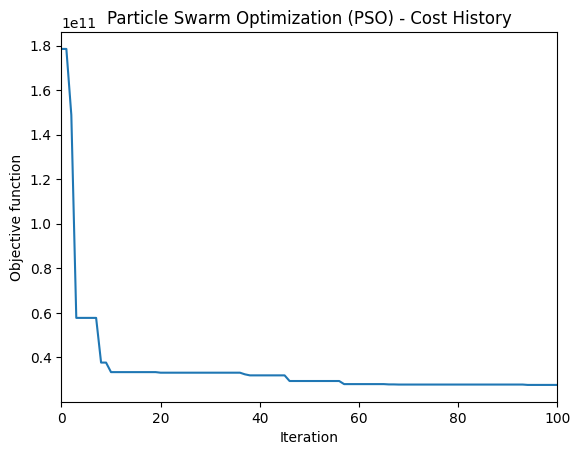

                              
*************************************************************************
Número total de iterações: 100
Número de Particulas: 100
Número de Dimensões: 24
                              
Melhor partícula: 234955560575.12558


In [992]:
# Plotar gráfico de densidade da otimização
plt.figure()
plt.plot(optimizer.cost_history)
plt.xlabel('Iteration')
plt.xlim(0, max_iterations)
plt.ylabel('Objective function')
plt.title('Particle Swarm Optimization (PSO) - Cost History')
plt.show()

print("                              ")
print("*************************************************************************")
print("Número total de iterações:", max_iterations)
print("Número de Particulas:", num_particles)
print("Número de Dimensões:", dimensions)
print("                              ")
print("Melhor partícula:", pbest_cost[0])

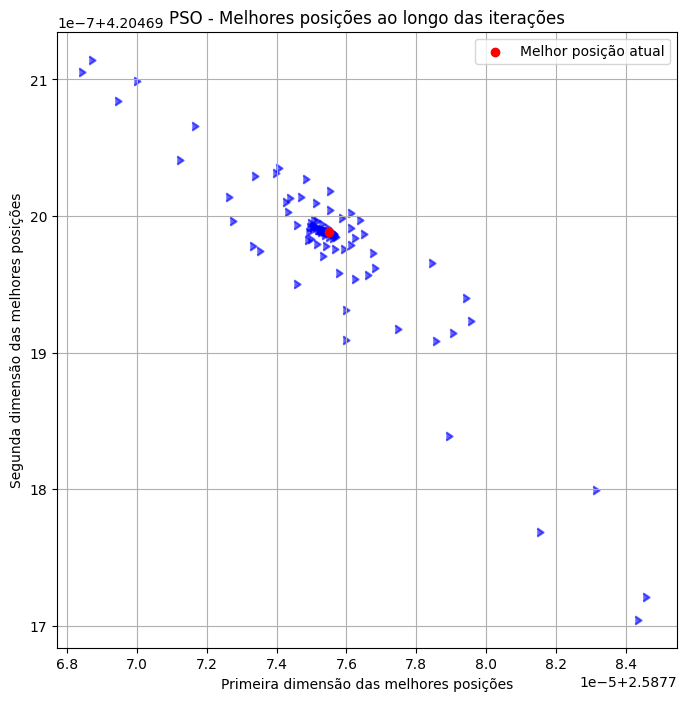

In [993]:
# Plotar o gráfico 3D com todas as melhores posições
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111)

# Plotar todas as melhores posições anteriores
for i in range(best_positions.shape[0]):
    ax.scatter(best_positions[i, 0], best_positions[i, 1], marker=m, c='blue', alpha=0.6)

# Plotar a última melhor posição com uma cor diferente para destacá-la
ax.scatter(best_positions[-1, 0], best_positions[-1, 1], c='red', label='Melhor posição atual')

ax.set_title('PSO - Melhores posições ao longo das iterações')
ax.set_xlabel('Primeira dimensão das melhores posições')
ax.set_ylabel('Segunda dimensão das melhores posições')
ax.legend()
plt.grid()
plt.show()